![Alt Text](img/box-office.avif)

# Box Office Movie Predictions

*By: Francisco José Pujalte Ferrándiz*

- Extracted from https://www.kaggle.com/competitions/tmdb-box-office-prediction/data

### Scope: using a Streamlit interface, try to **predict**, being a producer: which budget, genres, which actors, director, screenwriter, runtime, or release month, among others, would be the best for a project. The project consists in simulating a movie release, in order to see the way in which you could make more money in the best effective way.

- Imports:

In [506]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict, Counter
sns.set_theme(style="whitegrid")
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from collections import Counter
from lightgbm import LGBMClassifier, LGBMRegressor
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.metrics import mutual_info_score, classification_report, median_absolute_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings('ignore')
import re
import pickle

- Data Imports and visualization:

In [507]:
df = pd.read_csv('data/train.csv')

In [508]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [509]:
df.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


- The columns we care about now are: id, budget, genres, title, production_countries, release_date, runtime, original_language, cast, crew and REVENUE

In [510]:
df = df.drop(['belongs_to_collection', 'spoken_languages', 'homepage', 'Keywords', 'imdb_id', 'overview','popularity','poster_path', 'status','tagline','original_title'], axis=1)

## Step 1: **Inspection & Cleaning**

### Budget and Revenue incongruences

- We may find in this database loads of movies with budget 0 (which is not possible, every movie needs a budget), really lows budgets or really low revenues. We will apply some transformations to modify these.

In [511]:
print("We have", len(df[df.budget == 0]), "with budget = 0")

We have 812 with budget = 0


- We drop the 0 budget movies due to not being able to know the real budgets for them.

In [512]:
df = df[df.budget != 0]

In [513]:
df[(df.budget > 0) & (df.budget < 10000)].head()

,id,budget,genres,original_language,production_companies,production_countries,release_date,runtime,title,cast,crew,revenue
334,335,1,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",ta,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",5/5/03,140.0,Saamy,"[{'cast_id': 11, 'character': 'Aaruchamy', 'cr...","[{'credit_id': '52fe4782c3a36847f813999f', 'de...",3
347,348,12,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",en,"[{'name': 'Allied Filmmakers', 'id': 1755}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",10/16/96,84.0,The Wind in the Willows,"[{'cast_id': 2, 'character': 'Toad', 'credit_i...","[{'credit_id': '59ce7655c3a3686aca01a522', 'de...",1
365,366,7000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",en,"[{'name': 'Thinkfilm', 'id': 446}]","[{'iso_3166_1': 'US', 'name': 'United States o...",10/8/04,77.0,Primer,"[{'cast_id': 1, 'character': 'Aaron', 'credit_...","[{'credit_id': '52fe45e79251416c75066791', 'de...",424760
469,470,113,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",en,"[{'name': 'Columbia Pictures Corporation', 'id...","[{'iso_3166_1': 'US', 'name': 'United States o...",6/18/86,113.0,"The Karate Kid, Part II","[{'cast_id': 1, 'character': 'Daniel LaRusso',...","[{'credit_id': '52fe44c1c3a36847f80a82dd', 'de...",115103979
512,513,93,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,"[{'name': 'Lewis Gilbert Productions', 'id': 1...","[{'iso_3166_1': 'US', 'name': 'United States o...",1/28/11,107.0,From Prada to Nada,"[{'cast_id': 9, 'character': 'Nora', 'credit_i...","[{'credit_id': '52fe47bfc3a36847f8146211', 'de...",2500000


- Inspecting these last movies with a budget, we appreciate, searching on the Internet, that the numbers below 12 should be millions, the numbers in hundreds or almost 100 should be thousands, and we drop the rest for the sake of the prediction model, as they could be real cases as Following, or very amateur movies that do not follow the scope of these project

- A visual inspection was performed for this. Below you can find all the manual transformations I performed for the cleaning of budget and revenue. You can find the step by step in the notebooks.

In [514]:
df['budget'] = np.where(df['budget'] < 13, df['budget'] * 1000000, df['budget'])
df['budget'] = np.where(df['budget'] < 1000, df['budget'] * 1000, df['budget'])
df = df.loc[~((df['budget'] > 0) & (df['budget'] < 10000))]
df = df[df.title != "THX 1138"]
df = df[df.revenue != "The Girlfriend Experience"]
df = df[df.revenue != "Pi"]
df = df[df.revenue != "Deep Rising"]
df = df[df.revenue != "Christopher Columbus: The Discovery"]
df = df[df.revenue != "Running with Scissorse"]
df = df[df.revenue != "The Frighteners"]
df = df[df.revenue != "Bitter Moon"]
df = df[df.revenue != "Connie and Carla"]
df = df.loc[~((df['title'] == 'A Farewell to Arms') | (df['title'] == 'Zyzzyx Road'))]
df['revenue'] = np.where(df['revenue'] < 100, df['revenue'] * 1000000, df['revenue'])
df = df.loc[~((df['revenue'] < 1000))]
df = df.loc[~((df['revenue'] < 10000))]
df.loc[df['title'] == 'Special Forces', 'revenue'] = 3424648
df.loc[df['title'] == 'Deadfall', 'revenue'] = 1946254
df.loc[df['title'] == 'From the Land of the Moon', 'revenue'] = 6547983
df = df.loc[~((df['revenue'] < 100000))]
df.loc[df['title'] == "Henry's Crime", 'revenue'] = 2169799
df.loc[df['title'] == "31", 'revenue'] = 850419
df.loc[df['title'] == "Ten Canoes", 'revenue'] = 3360455
df.loc[df['title'] == "The Wild Bunch", 'revenue'] = 10500000
df.loc[df['title'] == "Happy Family", 'revenue'] = 1271669
df.loc[df['title'] == "Aquarius", 'revenue'] = 3085977
df.loc[df['title'] == "Adore", 'revenue'] = 1575749
df.loc[df['title'] == "Enter the Void", 'revenue'] = 1467278
df.loc[df['title'] == "Shadow Dancer", 'revenue'] = 2255291
df.loc[df['title'] == "Life of Crime", 'revenue'] = 1456675
df.loc[df['title'] == "Beyond the Mat", 'budget'] = 500000
df.loc[df['title'] == "Beyond the Mat", 'revenue'] = 2053648 # Beyond the Mat's revenue and budget were switched
df.loc[df['title'] == "The Monk", 'revenue'] = 1809527
df.loc[df['title'] == "The Face of Love", 'revenue'] = 1806548
df.loc[df['title'] == "Man-Thing", 'revenue'] = 1123136
df.loc[df['title'] == "I Spit on Your Grave", 'revenue'] = 1278650
df.loc[df['title'] == "My Life as a Zucchini", 'revenue'] = 5873157
df.loc[df['title'] == "Burn", 'revenue'] = 1109276
df = df.loc[~((df['title'] == 'The Informers'))]
df = df.loc[~((df['revenue'] < 1000000))]

### Genres

- First, we drop all the movies without a genre, and use this function in order to extract a list of the genres the movie is composed:

In [515]:
df = df.dropna(subset=['genres'])
df['genres'] = df['genres'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

In [516]:
df.genres[0:5]

0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
5      [Animation, Adventure, Family]
Name: genres, dtype: object

- Now I'm aiming to make a feature for the most successful genres:

In [517]:
genres_list = df["genres"].explode().tolist()
genresDict = Counter(genres_list)

- We use this function in order to create a dictionary with the most successful movies (best mean revenue).

In [518]:
topGenreDict = defaultdict(lambda: [0, 0])

for _, row in df.iterrows():
    revenue = row["revenue"]
    genres = row["genres"]
    
    for genre in genres:
        topGenreDict[genre][0] += revenue
        topGenreDict[genre][1] += 1

# Calculate mean revenues by genre
average_revenue_per_genre = {}
for genre in topGenreDict:
    total_revenue, count = topGenreDict[genre]
    if count > 0:
        average_revenue_per_genre[genre] = total_revenue / count
    else:
        average_revenue_per_genre[genre] = 0  # Avoid division by 0

# Order in descendent order
topGenreDict = OrderedDict(sorted(topGenreDict.items(), key=lambda x: x[1][0], reverse=True))

for genre in topGenreDict:
    print(f"Genre: {genre}, Total revenue: {topGenreDict[genre][0]}, Total amount: {topGenreDict[genre][1]}")

for genre, avg_revenue in average_revenue_per_genre.items():
    print(f"Genre: {genre}, Mean revenue: {avg_revenue}")

Genre: Action, Total revenue: 80350752217, Total amount: 582
Genre: Adventure, Total revenue: 75318286099, Total amount: 365
Genre: Drama, Total revenue: 65290574679, Total amount: 966
Genre: Comedy, Total revenue: 57393328715, Total amount: 674
Genre: Thriller, Total revenue: 52457620719, Total amount: 585
Genre: Science Fiction, Total revenue: 34977222585, Total amount: 227
Genre: Family, Total revenue: 34434324592, Total amount: 194
Genre: Fantasy, Total revenue: 33360985293, Total amount: 181
Genre: Romance, Total revenue: 28207087693, Total amount: 373
Genre: Crime, Total revenue: 26538088536, Total amount: 345
Genre: Animation, Total revenue: 20044566910, Total amount: 103
Genre: Horror, Total revenue: 15564605478, Total amount: 219
Genre: Mystery, Total revenue: 12716156739, Total amount: 167
Genre: War, Total revenue: 4951619965, Total amount: 76
Genre: History, Total revenue: 4870363805, Total amount: 96
Genre: Music, Total revenue: 4021949766, Total amount: 64
Genre: Western,

- These are the most successful genres. Action normally is the genre that has higher revenues, followed up by Adventure, Drama and Comedy.

In [519]:
topGenreDict

OrderedDict([('Action', [80350752217, 582]),
             ('Adventure', [75318286099, 365]),
             ('Drama', [65290574679, 966]),
             ('Comedy', [57393328715, 674]),
             ('Thriller', [52457620719, 585]),
             ('Science Fiction', [34977222585, 227]),
             ('Family', [34434324592, 194]),
             ('Fantasy', [33360985293, 181]),
             ('Romance', [28207087693, 373]),
             ('Crime', [26538088536, 345]),
             ('Animation', [20044566910, 103]),
             ('Horror', [15564605478, 219]),
             ('Mystery', [12716156739, 167]),
             ('War', [4951619965, 76]),
             ('History', [4870363805, 96]),
             ('Music', [4021949766, 64]),
             ('Western', [2047839318, 29]),
             ('Documentary', [197220094, 14]),
             ('TV Movie', [42000000, 1]),
             ('Foreign', [17288952, 6])])

- Using getGenreRank, we create a new feature which represents, using the genres the movie is composed of, a ranking. It will do the mean between the positions in the ranking and the total genres of the movie.

In [520]:
genre_index_dict = {genre: index for index, genre in enumerate(topGenreDict.keys())}

def getGenreRank(genres):
    total_rank = sum(genre_index_dict[g] for g in genres)
    return total_rank / len(genres)

df['genre_rank'] = df['genres'].apply(lambda x: getGenreRank(x) if len(x) > 0 else 0)

- All the dictionaries are saved in the folder imports for future purposes in the project presentation.

### Cast

- I drop all the movies with no cast or a string simulating an empty list.

In [521]:
df = df.dropna(subset=['cast'])
df = df[df['cast'] != '[]']

- We use the following function in order to extract the names of the actors and the cast from the structure.

In [522]:
import ast 
def extraer(dict_string):
    list_of_dicts = ast.literal_eval(dict_string)
    names = [dic['name'] for dic in list_of_dicts]
    return names
def extraer_actores(lista_de_actores):
    actor_principal = lista_de_actores[0] if len(lista_de_actores) > 0 else None
    actor_reparto_1 = lista_de_actores[1] if len(lista_de_actores) > 1 else None
    actor_reparto_2 = lista_de_actores[2] if len(lista_de_actores) > 2 else None
    return actor_principal, actor_reparto_1, actor_reparto_2

df['cast'] = df['cast'].apply(extraer)
df[['lead_actor', 'supporting_actor_1', 'supporting_actor_2']] = df['cast'].apply(
    lambda x: pd.Series(extraer_actores(x))
)

df.cast[0]

['Rob Corddry',
 'Craig Robinson',
 'Clark Duke',
 'Adam Scott',
 'Chevy Chase',
 'Gillian Jacobs',
 'Bianca Haase',
 'Collette Wolfe',
 'Kumail Nanjiani',
 'Kellee Stewart',
 'Josh Heald',
 'Gretchen Koerner',
 'Lisa Loeb',
 'Jessica Williams',
 'Bruce Buffer',
 'Mariana Paola Vicente',
 'Christian Slater',
 'Jason Jones',
 'Olivia Jordan',
 'Christine Bently',
 'Stacey Asaro',
 'John Cusack',
 'Adam Herschman',
 'Kisha Sierra']

- It is also necessary to drop the movies with have no supporting actors, for future training purposes.

In [523]:
df = df.dropna(subset=['supporting_actor_1', 'supporting_actor_2'])

- When it comes to do a ranking similar to the genres, now with actors, we use the following function. In order to avoid the actors which only have a very few but successful movies, we establish the movie limit in more than 5. We then calculate the average revenue for every actor, order them and rank them.

In [524]:
topActorDict = defaultdict(lambda: [0, 0])

for _, row in df.iterrows():
    revenue = row["revenue"]
    actors = row["cast"]
    
    for actor in actors:
        topActorDict[actor][0] += revenue
        topActorDict[actor][1] += 1

# Filter actors with less than 6 movies made
filtered_actors = {actor: stats for actor, stats in topActorDict.items() if stats[1] > 5}

average_revenue_per_actor = {}
for actor, (total_revenue, count) in filtered_actors.items():
    average_revenue_per_actor[actor] = total_revenue / count

sorted_actors = sorted(average_revenue_per_actor.items(), key=lambda x: x[1], reverse=True)
topActorDict = OrderedDict(sorted_actors)

# Average revenue per actor
for actor, avg_revenue in topActorDict.items():
    print(f"Actor: {actor}, Ingreso Promedio: {avg_revenue}")

Actor: Stan Lee, Ingreso Promedio: 856190649.875
Actor: Luke Evans, Ingreso Promedio: 684166188.8333334
Actor: Jess Harnell, Ingreso Promedio: 653163711.25
Actor: Orlando Bloom, Ingreso Promedio: 650910908.7142857
Actor: Andy Serkis, Ingreso Promedio: 627736137.8888888
Actor: Ian McKellen, Ingreso Promedio: 621432050.5454545
Actor: Jed Brophy, Ingreso Promedio: 612949691.3333334
Actor: John DiMaggio, Ingreso Promedio: 582649642.8333334
Actor: Hugo Weaving, Ingreso Promedio: 582574341.5454545
Actor: Emma Watson, Ingreso Promedio: 581954504.8333334
Actor: Christopher Lee, Ingreso Promedio: 576116584.1
Actor: Tyrese Gibson, Ingreso Promedio: 566860816.0
Actor: Peter Cullen, Ingreso Promedio: 561860039.8333334
Actor: Jeremy Renner, Ingreso Promedio: 516149281.3333333
Actor: Shia LaBeouf, Ingreso Promedio: 511103429.125
Actor: Josh Duhamel, Ingreso Promedio: 499268644.14285713
Actor: Alan Tudyk, Ingreso Promedio: 484085879.2222222
Actor: Alan Rickman, Ingreso Promedio: 483482554.28571427
Ac

- Next, the actor ranking is calculated bearing in mind the topActorDict dictionary, which is composed by the most successful actors. If the movie has an actor not recognized, it asigns him/her with the worst ranking. It will do the mean between the first 5 actors of the cast.

In [525]:
actor_rank_dict = {} 
for idx, actor in enumerate(sorted(topActorDict, key=topActorDict.get, reverse=True)):
    actor_rank_dict[actor] = idx + 1

def calculate_actor_ranking(actors):
    if isinstance(actors, list):
        rankings = []
        for actor in actors:
            if actor in actor_rank_dict:
                rankings.append(actor_rank_dict[actor])
            else:
                rankings.append(len(topActorDict) + 1) 
        return sum(rankings) / len(rankings) if len(rankings) > 0 else len(topActorDict) + 1
    else:
        return len(topActorDict) + 1

In [526]:
df['actors'] = df['cast'].apply(lambda x: x[:5])
df['actor_rank'] = df['actors'].apply(calculate_actor_ranking)

- We will also create a feature which counts the amount of actors in the movie that are in the Top 100 most successful, now with limit 3 movies minimum.

In [527]:
def calculate_average_revenue_per_actor(df):
    actor_revenue = Counter()
    actor_count = Counter()
    
    for index, row in df.iterrows():
        cast = row['cast']
        revenue = row['revenue']
        for actor in cast:
            actor_revenue[actor] += revenue
            actor_count[actor] += 1
    
    actors_to_remove = [actor for actor in actor_count if actor_count[actor] < 3]
    for actor in actors_to_remove:
        del actor_revenue[actor]
    
    average_revenue = {actor: actor_revenue[actor] / actor_count[actor] for actor in actor_revenue}
    
    return average_revenue

average_revenue_per_actor = calculate_average_revenue_per_actor(df)
average_revenue_df = pd.DataFrame(list(average_revenue_per_actor.items()), columns=['actor', 'average_revenue'])
top_100_actors = average_revenue_df.nlargest(100, 'average_revenue')
top_100_actors_set = set(top_100_actors['actor'])

def count_top_100_actors(cast):
    return sum(1 for actor in cast if actor in top_100_actors_set)

df['top_100_actor_count'] = df['actors'].apply(lambda x: count_top_100_actors(x))

In [528]:
df.top_100_actor_count.value_counts()

top_100_actor_count
0    1885
1      79
2       7
3       6
4       1
Name: count, dtype: int64

Now we have a feature that bears in mind the most successful actors, and for example, the one who leads this feature with 4 actors in "The Avengers"

### Crew

- The procedure to follow will be very similar to actors. We are going to extract the directors and screenwriters from all the movies, discard the ones that do not have, and calculate:
1. A ranking for the most successful directors and screenwriters
2. A binary feature if the movie's directors or screenwriters has a Top 25 Director or Screenwriter

In [529]:
df = df.dropna(subset=['crew'])

def extract_director(credits):
    data = ast.literal_eval(credits)
    director = next((dic['name'] for dic in data if dic['job'] == 'Director'), None)
    return director

def extract_writer(credits):
    data = ast.literal_eval(credits)
    writer = next((dic['name'] for dic in data if dic['department'] == 'Writing'), None)
    return writer

df['director'] = df['crew'].apply(extract_director)
df['writer'] = df['crew'].apply(extract_writer)

df = df.dropna(subset=['writer'])

- We also corrected these important director's name:

In [530]:
df['director'] = df['director'].replace('Alejandro Gonz√°lez I√±√°rritu', 'Alejandro González Iñárritu')
df['director'] = df['director'].replace('Alfonso Cuar√≥n', 'Alfonso Cuarón')
df['writer'] = df['writer'].replace('Alejandro Gonz√°lez I√±√°rritu', 'Alejandro González Iñárritu')

df['director'] = df['director'].astype(str)
df['writer'] = df['writer'].astype(str)

- Now, the functions in order to extract the rankings and counts.

In [531]:
directorRevenueDict = defaultdict(lambda: [0, 0])
for _, row in df.iterrows():
    revenue = row["revenue"]
    director = row["director"]
    
    directorRevenueDict[director][0] += revenue
    directorRevenueDict[director][1] += 1

average_revenue_per_director = {}
for director, (total_revenue, count) in directorRevenueDict.items():
    if count > 0:
        average_revenue_per_director[director] = total_revenue / count
    else:
        average_revenue_per_director[director] = 0 

sorted_directors = sorted(average_revenue_per_director.items(), key=lambda x: x[1], reverse=True)
topDirectorDict = OrderedDict((director, avg_revenue) for director, avg_revenue in sorted_directors)

for director, avg_revenue in topDirectorDict.items():
    print(f"Director: {director}, Ingreso Promedio: {avg_revenue}")

Director: Joss Whedon, Ingreso Promedio: 1462480802.0
Director: Byron Howard, Ingreso Promedio: 1023784195.0
Director: David Yates, Ingreso Promedio: 933959197.0
Director: James Gunn, Ingreso Promedio: 818372385.0
Director: Roger Allers, Ingreso Promedio: 788241776.0
Director: Tim Miller, Ingreso Promedio: 783112979.0
Director: Robert Stromberg, Ingreso Promedio: 758539785.0
Director: George Lucas, Ingreso Promedio: 749699164.0
Director: Alfonso Cuarón, Ingreso Promedio: 716392705.0
Director: Anthony Russo, Ingreso Promedio: 714766572.0
Director: Carlos Saldanha, Ingreso Promedio: 682605344.0
Director: Zack Snyder, Ingreso Promedio: 662845518.0
Director: Peter Jackson, Ingreso Promedio: 635720590.5714285
Director: Andrew Stanton, Ingreso Promedio: 611340616.3333334
Director: Dean DeBlois, Ingreso Promedio: 609123048.0
Director: Rob Marshall, Ingreso Promedio: 603978382.0
Director: Andrew Adamson, Ingreso Promedio: 584229185.0
Director: David Silverman, Ingreso Promedio: 527068851.0
Dir

In [532]:
def calculate_average_revenue_per_director(df):
    director_revenue = {}
    director_count = {}
    
    for index, row in df.iterrows():
        director = row['director']
        revenue = row['revenue']
        if director in director_revenue:
            director_revenue[director] += revenue
            director_count[director] += 1
        else:
            director_revenue[director] = revenue
            director_count[director] = 1
    
    for director in list(director_revenue.keys()):
        if director_count[director] < 3:
            del director_revenue[director]
            del director_count[director]
    
    average_revenue = {director: director_revenue[director] / director_count[director] for director in director_revenue}
    
    return average_revenue

average_revenue_per_director = calculate_average_revenue_per_director(df)
average_revenue_dir_df = pd.DataFrame(list(average_revenue_per_director.items()), columns=['director', 'average_revenue'])
top_25_directors = average_revenue_dir_df.nlargest(25, 'average_revenue')
top_25_directors_set = set(top_25_directors['director'])

def has_top_25_director(director):
    return 1 if director in top_25_directors_set else 0

In [533]:
director_rank_dict = {} 

for idx, director in enumerate(sorted(topDirectorDict, key=topDirectorDict.get, reverse=True)):
    director_rank_dict[director] = idx + 1

def calculate_director_ranking(director):
    if isinstance(director, str):
        return director_rank_dict.get(director, len(topDirectorDict) + 1)
    else:
        return len(topDirectorDict) + 1

In [534]:
writerRevenueDict = defaultdict(lambda: [0, 0])

for _, row in df.iterrows():
    revenue = row["revenue"]
    writer = row["writer"]
    
    writerRevenueDict[writer][0] += revenue
    writerRevenueDict[writer][1] += 1

average_revenue_per_writer = {}
for writer, (total_revenue, count) in writerRevenueDict.items():
    if count > 0:
        average_revenue_per_writer[writer] = total_revenue / count
    else:
        average_revenue_per_writer[writer] = 0 

sorted_writers = sorted(average_revenue_per_writer.items(), key=lambda x: x[1], reverse=True)
topWriterDict = OrderedDict((writer, avg_revenue) for writer, avg_revenue in sorted_writers)

for writer, avg_revenue in topWriterDict.items():
    print(f"Escritor: {writer}, Ingreso Promedio: {avg_revenue}")

Escritor: Stan Lee, Ingreso Promedio: 1085180441.0
Escritor: Jared Bush, Ingreso Promedio: 1023784195.0
Escritor: Fran Walsh, Ingreso Promedio: 1021103568.0
Escritor: J.K. Rowling, Ingreso Promedio: 905323839.5
Escritor: Linda Woolverton, Ingreso Promedio: 892015447.5
Escritor: Chris Morgan, Ingreso Promedio: 832358826.0
Escritor: James Gunn, Ingreso Promedio: 818372385.0
Escritor: Jonathan Roberts, Ingreso Promedio: 788241776.0
Escritor: Ted Elliott, Ingreso Promedio: 779772048.5
Escritor: Alfonso Cuar√≥n, Ingreso Promedio: 716392705.0
Escritor: Melissa Rosenberg, Ingreso Promedio: 704159404.5
Escritor: George Lucas, Ingreso Promedio: 703602613.0
Escritor: Jon Vitti, Ingreso Promedio: 660940780.0
Escritor: Danny Strong, Ingreso Promedio: 653428261.0
Escritor: Jonathan Hales, Ingreso Promedio: 649398328.0
Escritor: Stephen Chbosky, Ingreso Promedio: 647278478.5
Escritor: Michael Berg, Ingreso Promedio: 634971976.5
Escritor: Drew Goddard, Ingreso Promedio: 630161890.0
Escritor: J.R.R. T

In [535]:
def calculate_average_revenue_per_writer(df):
    writer_revenue = {}
    writer_count = {}
    
    for index, row in df.iterrows():
        writer = row['writer']
        revenue = row['revenue']
        if writer in writer_revenue:
            writer_revenue[writer] += revenue
            writer_count[writer] += 1
        else:
            writer_revenue[writer] = revenue
            writer_count[writer] = 1
    
    for writer in list(writer_revenue.keys()):
        if writer_count[writer] < 3:
            del writer_revenue[writer]
            del writer_count[writer]
    
    average_revenue = {writer: writer_revenue[writer] / writer_count[writer] for writer in writer_revenue}
    
    return average_revenue

average_revenue_per_writer = calculate_average_revenue_per_writer(df)
average_revenue_wri_df = pd.DataFrame(list(average_revenue_per_writer.items()), columns=['writer', 'average_revenue'])
top_25_writers = average_revenue_wri_df.nlargest(25, 'average_revenue')
top_25_writers_set = set(top_25_writers['writer'])

def has_top_25_writer(writer):
    return 1 if writer in top_25_writers_set else 0

In [536]:
writer_rank_dict = {}

for idx, writer in enumerate(sorted(topWriterDict, key=topWriterDict.get, reverse=True)):
    writer_rank_dict[writer] = idx + 1

def calculate_writer_ranking(writer):
    if isinstance(writer, str):
        return writer_rank_dict.get(writer, len(topWriterDict) + 1)
    else:
        return len(topWriterDict) + 1

In [537]:
df['writer_rank'] = df['writer'].apply(calculate_writer_ranking)
df['director_rank'] = df['director'].apply(calculate_director_ranking)
df['has_top_25_writer'] = df['writer'].apply(lambda x: has_top_25_writer(x))
df['has_top_25_director'] = df['director'].apply(lambda x: has_top_25_director(x))
df = df.drop(['crew'], axis=1)

In [538]:
top_25_directors

,director,average_revenue
12,Carlos Saldanha,6.826053e+08
28,Peter Jackson,6.357206e+08
41,Andrew Stanton,6.113406e+08
164,Brad Bird,5.117699e+08
81,Christopher Nolan,4.961511e+08
58,Francis Lawrence,4.898873e+08
99,Michael Bay,4.883441e+08
112,Bill Condon,4.754597e+08
83,Gore Verbinski,4.715684e+08
156,John Lasseter,4.651299e+08


In [539]:
top_25_writers

,writer,average_revenue
73,Stan Lee,1.085180e+09
108,Ted Elliott,7.797720e+08
62,George Lucas,7.036026e+08
17,J.R.R. Tolkien,6.200799e+08
24,Andrew Stanton,6.113406e+08
14,Ehren Kruger,5.533676e+08
49,Christopher Nolan,4.961511e+08
85,Akiva Goldsman,4.329437e+08
44,Peter Jackson,3.997931e+08
23,Ian Fleming,2.822290e+08


### Original Language

In [540]:
df.original_language.value_counts()

original_language
en    1749
hi      36
fr      29
ru      20
ja      17
es      14
ta      12
zh      11
ko      10
de       8
it       8
cn       7
pt       4
pl       2
nl       2
da       2
sv       2
id       1
ro       1
el       1
nb       1
no       1
he       1
te       1
ml       1
Name: count, dtype: int64

- Most of it is in English, so we're creating a new feature to represent it.

In [541]:
df['in_english'] = df.original_language.apply(lambda x: 1 if x == 'en' else 0)
df.drop(columns=['original_language'], inplace=True)

### Production Companies

- For Production Companies, we are filling the NaN values with empty strings, and extract the names of the companies in every movie. We also create a new feature, the number of the companies involved in the movie. We will also proceed to create a new ranking of the most successful companies (3 or 5 movies limit), same procedure as with actors, directors and screenwriters.

In [542]:
df['production_companies'] = df['production_companies'].fillna('')
df['production_companies'] = df['production_companies'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

In [543]:
topCompanyDict = defaultdict(lambda: [0, 0])

movie_count = defaultdict(int)
for _, row in df.iterrows():
    revenue = row["revenue"]
    companies = row["production_companies"]
    for company in companies:
        movie_count[company] += 1
        topCompanyDict[company][0] += revenue
        topCompanyDict[company][1] += 1

topCompanyDict = {company: total_revenue / count for company, (total_revenue, count) in topCompanyDict.items() if movie_count[company] > 3}
topCompanyDict = OrderedDict(sorted(topCompanyDict.items(), key=lambda x: x[1], reverse=True))

In [544]:
def calculate_average_revenue_per_company(df):
    company_revenue = {}
    company_count = {}
    
    for index, row in df.iterrows():
        companies = row['production_companies']
        revenue = row['revenue']
        for company in companies:
            if company in company_revenue:
                company_revenue[company] += revenue
                company_count[company] += 1
            else:
                company_revenue[company] = revenue
                company_count[company] = 1
    
    for company in list(company_revenue.keys()):
        if company_count[company] < 5:
            del company_revenue[company]
            del company_count[company]
    
    average_revenue = {company: company_revenue[company] / company_count[company] for company in company_revenue}
    
    return average_revenue

average_revenue_per_company = calculate_average_revenue_per_company(df)
average_revenue_company_df = pd.DataFrame(list(average_revenue_per_company.items()), columns=['production_company', 'average_revenue'])
top_25_companies = average_revenue_company_df.nlargest(25, 'average_revenue')
top_25_companies_set = set(top_25_companies['production_company'])

def has_top_25_company(companies):
    return 1 if any(company in top_25_companies_set for company in companies) else 0

In [545]:
company_rank_dict = {}  # Usar un diccionario estándar

# Asignar el ranking a cada compañía en company_rank_dict
for idx, company in enumerate(sorted(topCompanyDict, key=topCompanyDict.get, reverse=True)):
    company_rank_dict[company] = idx + 1

def calculate_company_ranking(companies):
    if isinstance(companies, list):
        rankings = []
        for company in companies:
            rank = company_rank_dict.get(company, len(topCompanyDict) + 1)  # Uso de get con valor por defecto
            rankings.append(rank)
        return sum(rankings) / len(rankings) if len(rankings) > 0 else len(topCompanyDict) + 1
    else:
        return len(topCompanyDict) + 1

In [546]:
df['has_top_25_company'] = df['production_companies'].apply(lambda x: has_top_25_company(x))
df['num_production_companies'] = df['production_companies'].apply(lambda x: len(x))
df['company_rank'] = df['production_companies'].apply(calculate_company_ranking)

In [547]:
topCompanyDict

OrderedDict([('Marvel Studios', 1055294589.2),
             ('Hasbro Studios', 818674036.75),
             ('Revolution Sun Studios', 655469382.875),
             ('Jerry Bruckheimer Films', 561781952.2857143),
             ('WingNut Films', 559200424.0),
             ('Syncopy', 537824736.5),
             ('Pixar Animation Studios', 532351327.875),
             ('DC Entertainment', 510827266.0),
             ('Temple Hill Entertainment', 506685642.25),
             ('Blue Sky Studios', 458239231.0),
             ('Sunswept Entertainment', 452348692.25),
             ('Lucasfilm', 449454802.14285713),
             ('Moving Picture Company (MPC)', 445917392.0),
             ('Di Bonaventura Pictures', 425142483.3333333),
             ('Walt Disney Feature Animation', 418655834.25),
             ('Twentieth Century Fox Animation', 418150106.0),
             ('Roth Films', 399338626.6),
             ('Dentsu', 379458715.14285713),
             ('Marvel Entertainment', 378937150.75),
     

In [548]:
top_25_companies

,production_company,average_revenue
162,Marvel Studios,1.055295e+09
163,Revolution Sun Studios,6.554694e+08
159,Jerry Bruckheimer Films,5.617820e+08
47,WingNut Films,5.592004e+08
67,Pixar Animation Studios,5.323513e+08
24,Blue Sky Studios,4.582392e+08
129,Lucasfilm,4.494548e+08
130,Moving Picture Company (MPC),4.459174e+08
106,Di Bonaventura Pictures,4.251425e+08
25,Twentieth Century Fox Animation,4.181501e+08


### Production Countries

- Regarding production countries, we created two features: the number of production countries, and if the United States is in it, as the vast majority of movies were produced there.

In [549]:
df.production_countries = df.production_countries.fillna("")
df['production_countries'] = df['production_countries'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))

In [550]:
df.production_countries[0:10]

0             [United States of America]
1             [United States of America]
2             [United States of America]
3                                [India]
5                                     []
6     [United States of America, Canada]
9             [United States of America]
10            [United States of America]
12            [United States of America]
13            [United States of America]
Name: production_countries, dtype: object

In [551]:
df['num_production_countries'] = df['production_countries'].apply(lambda x: len(x))
df['produced_in_US'] = df.production_countries.apply(lambda x: 1 if 'United States of America' in x else 0)
df.drop(columns=['production_countries'], inplace=True)

In [552]:
df.produced_in_US.value_counts()

produced_in_US
1    1637
0     304
Name: count, dtype: int64

### Release date

- Release date is a feature with a lot of information. From it we can extract the month, the year, the decade, the season of the year...

In [553]:
df['release_date'] = df['release_date'].apply(str)

estaciones = {
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
    5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'
}

def extraer_mes(fecha):
    try:
        # Diccionario de meses
        meses = {
            '1': 'January', '2': 'February', '3': 'March', '4': 'April',
            '5': 'May', '6': 'June', '7': 'July', '8': 'August',
            '9': 'September', '10': 'October', '11': 'November', '12': 'December'
        }
        
        # Extraer el mes de la fecha en formato 'MM/DD/YY'
        mes_num = fecha.split('/')[0]
        
        # Obtener el nombre del mes usando el diccionario
        nombre_mes = meses.get(mes_num, None)
        
        return nombre_mes
    except (AttributeError, IndexError):
        return None
    
def extraer_anio(fecha):
    anio = fecha[-2:]
    if int(anio) <= 24:
        anio = '20' + anio
    else:
        anio = '19' + anio
    return anio
    
def obtener_decada(year):
    if 1920 <= year < 1930:
        return "1920s"
    if 1930 <= year < 1940:
        return "1930s"
    if 1940 <= year < 1950:
        return "1940s"
    if 1950 <= year < 1960:
        return "1950s"
    if 1960 <= year < 1970:
        return "1960s"
    elif 1970 <= year < 1980:
        return "1970s"
    elif 1980 <= year < 1990:
        return "1980s"
    elif 1990 <= year < 2000:
        return "1990s"
    elif 2000 <= year < 2010:
        return "2000s"
    elif 2010 <= year < 2020:
        return "2010s"
    else:
        return "2020s"

def extract_season(date):
    try:
        month_num = int(date.split('/')[0])
        
        if month_num in [3, 4, 5]:
            return 'Spring'
        elif month_num in [6, 7, 8]:
            return 'Summer'
        elif month_num in [9, 10, 11]:
            return 'Autumn'
        elif month_num in [12, 1, 2]:
            return 'Winter'
        else:
            return None  # Return None for invalid month
    except (AttributeError, IndexError, ValueError):
        return None

df['release_month'] = df['release_date'].apply(extraer_mes)
df['release_year'] = df['release_date'].apply(extraer_anio)
df['release_year'] = df['release_year'].apply(int)
df['decade'] = df['release_year'].apply(obtener_decada)
df['season'] = df['release_date'].apply(extract_season)

- We extract the different seasons, weeks of the year, months, etc., because the revenue will be different depending on it, if people are more eager to go to the cinema, it's Summer, it's Christmas, etc

### Runtime

In [554]:
print('Movies with no runtime: ',len(df[df.runtime == 0]))

Movies with no runtime:  4


- There are 4 movies with no runtime, so we apply the median to them.

In [555]:
median = df.loc[df['runtime'] > 0, 'runtime'].median()
df['runtime'] = df['runtime'].apply(lambda x: median if x == 0 else x)

In [556]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1941 entries, 0 to 2999
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1941 non-null   int64  
 1   budget                    1941 non-null   int64  
 2   genres                    1941 non-null   object 
 3   production_companies      1941 non-null   object 
 4   release_date              1941 non-null   object 
 5   runtime                   1941 non-null   float64
 6   title                     1941 non-null   object 
 7   cast                      1941 non-null   object 
 8   revenue                   1941 non-null   int64  
 9   genre_rank                1941 non-null   float64
 10  lead_actor                1941 non-null   object 
 11  supporting_actor_1        1941 non-null   object 
 12  supporting_actor_2        1941 non-null   object 
 13  actors                    1941 non-null   object 
 14  actor_rank   

## Step 2: **Exploratory Data Analysis**

### **Univariate** analysis

### Movie **runtime**

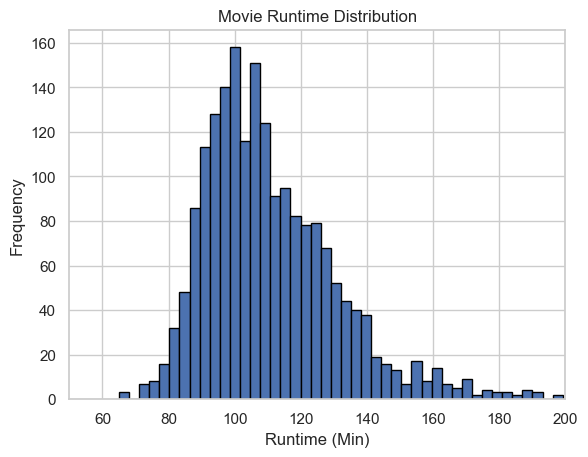

In [557]:
df['runtime'].hist(bins=60, edgecolor='black')
plt.title('Movie Runtime Distribution')
plt.xlabel('Runtime (Min)')
plt.ylabel('Frequency')
plt.xlim([50,200])
plt.show()

### **Budget**

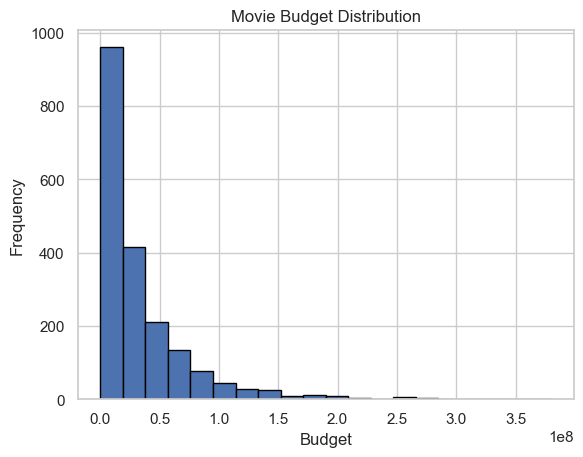

In [558]:
df['budget'].hist(bins=20, edgecolor='black')
plt.title('Movie Budget Distribution')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()

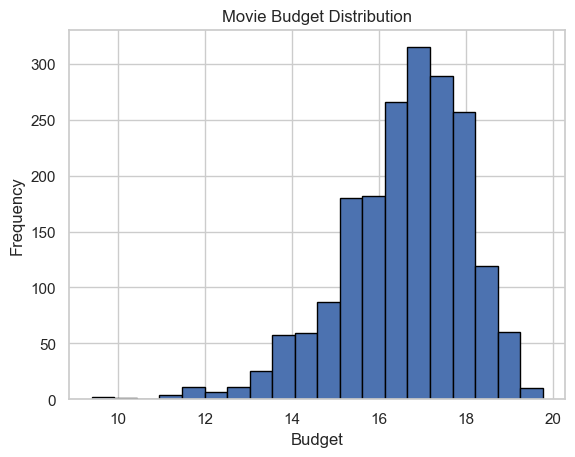

In [559]:
np.log1p(df['budget']).hist(bins=20, edgecolor='black')
plt.title('Movie Budget Distribution')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()

### **Revenue**

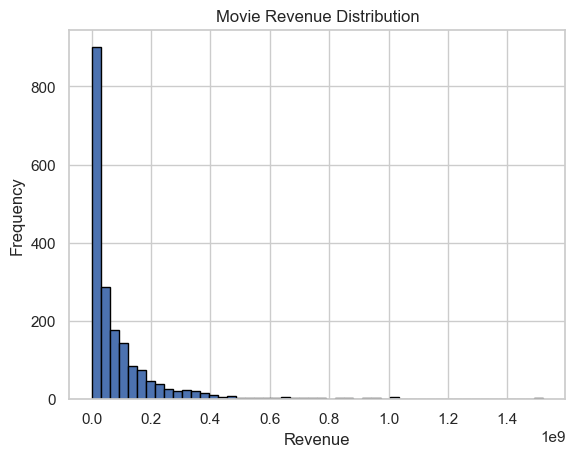

In [560]:
df['revenue'].hist(bins=50, edgecolor='black')
plt.title('Movie Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

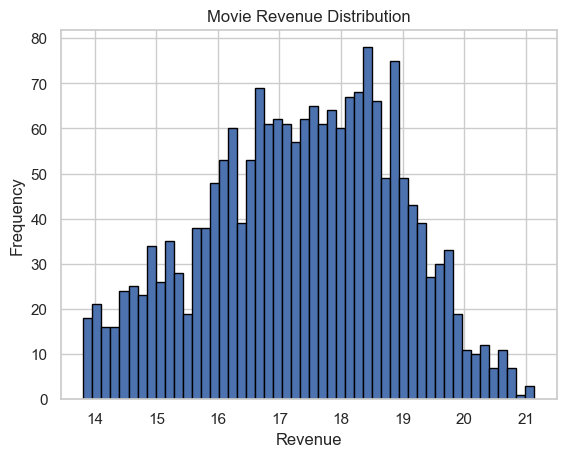

In [561]:
np.log1p(df['revenue']).hist(bins=50, edgecolor='black')
plt.title('Movie Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

### **Ranks**

- Actor:

In [562]:
df.actor_rank

0       746.20
1       386.20
2       735.20
3       835.00
5       650.25
         ...  
2992    835.00
2993    462.60
2997    678.60
2998    532.60
2999    612.20
Name: actor_rank, Length: 1941, dtype: float64

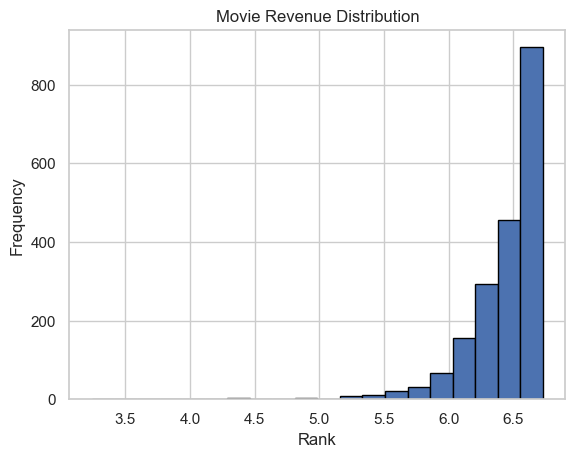

In [563]:
np.log1p(df['actor_rank']).hist(bins=20, edgecolor='black')
plt.title('Movie Revenue Distribution')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

### **Cast & Crew** features

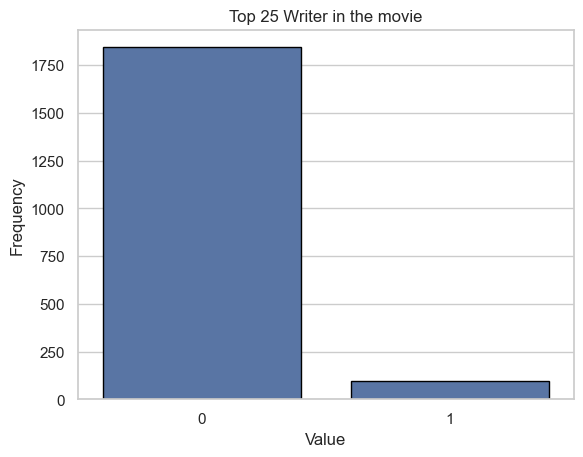

In [564]:
sns.countplot(x='has_top_25_writer', data=df, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top 25 Writer in the movie')
plt.show()

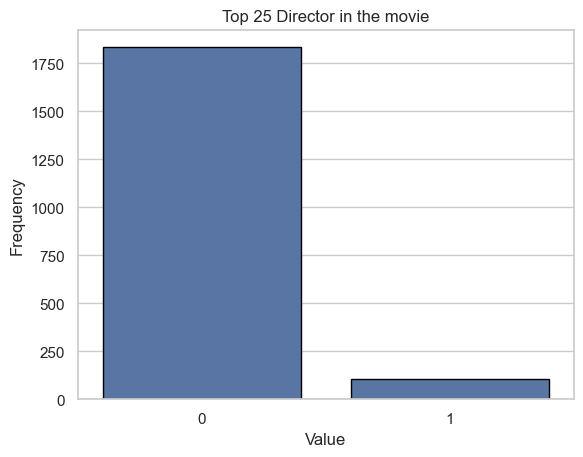

In [565]:
sns.countplot(x='has_top_25_director', data=df, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top 25 Director in the movie')
plt.show()

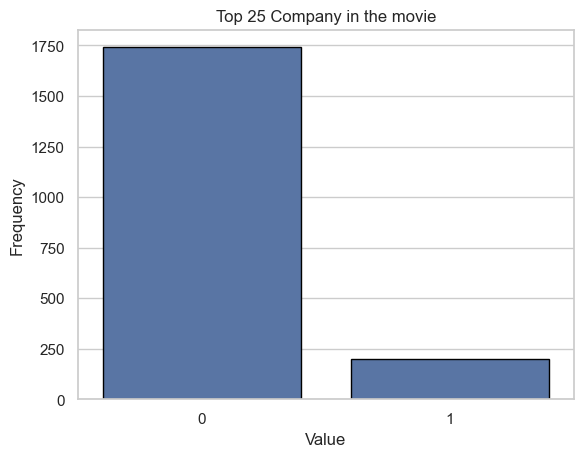

In [566]:
sns.countplot(x='has_top_25_company', data=df, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top 25 Company in the movie')
plt.show()

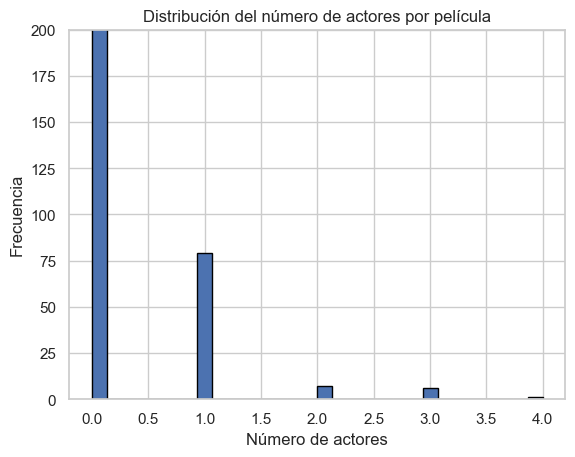

In [567]:
plt.hist(df['top_100_actor_count'], bins=30, edgecolor='black')
plt.xlabel('Número de actores')
plt.ylabel('Frecuencia')
plt.title('Distribución del número de actores por película')
plt.ylim([0,200])
plt.show()

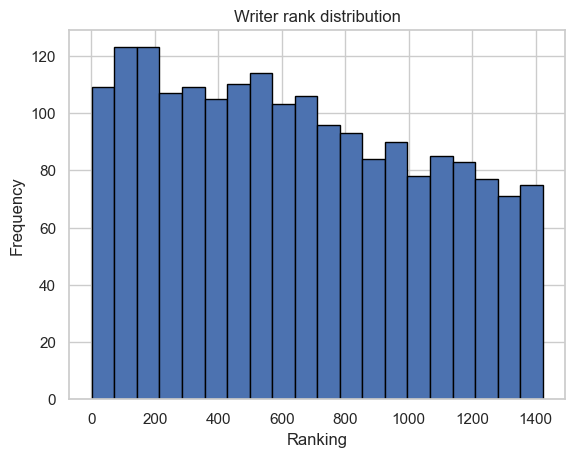

In [568]:
plt.hist(df['writer_rank'], bins=20, edgecolor='black')
plt.xlabel('Ranking')
plt.ylabel('Frequency')
plt.title('Writer rank distribution')
plt.show()

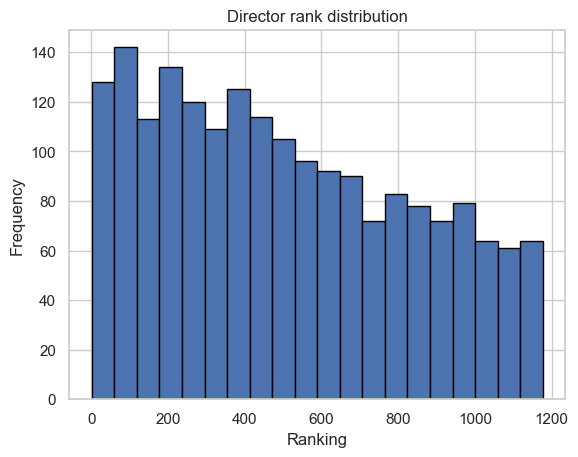

In [569]:
plt.hist(df['director_rank'], bins=20, edgecolor='black')
plt.xlabel('Ranking')
plt.ylabel('Frequency')
plt.title('Director rank distribution')
plt.show()

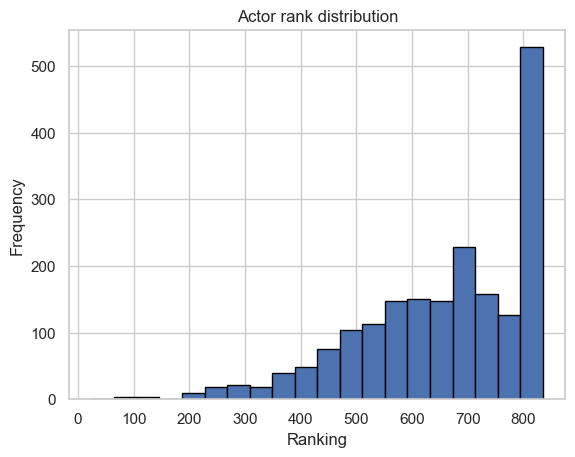

In [570]:
plt.hist(df['actor_rank'], bins=20, edgecolor='black')
plt.xlabel('Ranking')
plt.ylabel('Frequency')
plt.title('Actor rank distribution')
plt.show()

### **Production companies**

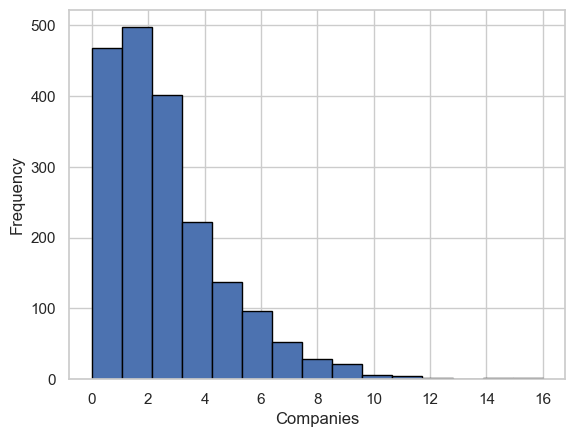

In [571]:
plt.hist(df['num_production_companies'], bins=15, edgecolor='black')
plt.xlabel('Companies')
plt.ylabel('Frequency')
plt.title('')
plt.show()

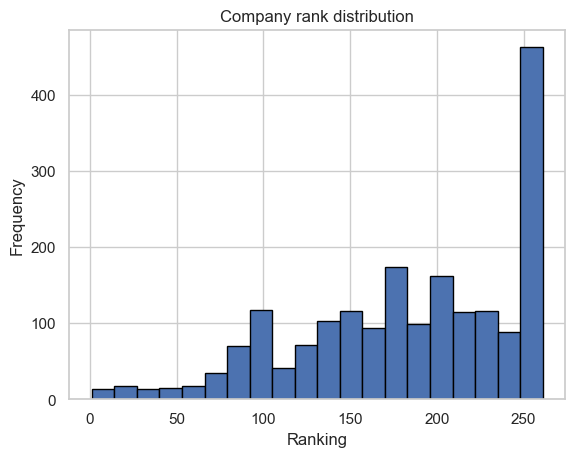

In [572]:
plt.hist(df['company_rank'], bins=20, edgecolor='black')
plt.xlabel('Ranking')
plt.ylabel('Frequency')
plt.title('Company rank distribution')
plt.show()

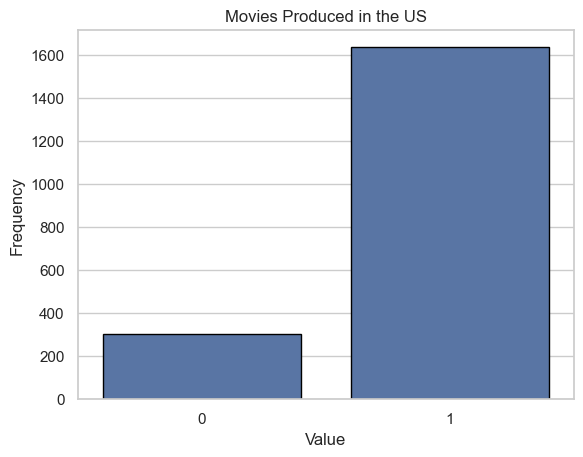

In [573]:
sns.countplot(x='produced_in_US', data=df, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Movies Produced in the US')
plt.show()

### **Language**

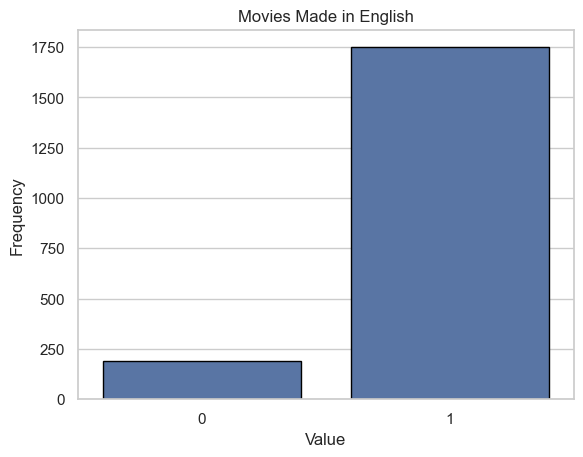

In [574]:
sns.countplot(x='in_english', data=df, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Movies Made in English')
plt.show()

### **Release date related** features

- Release year:

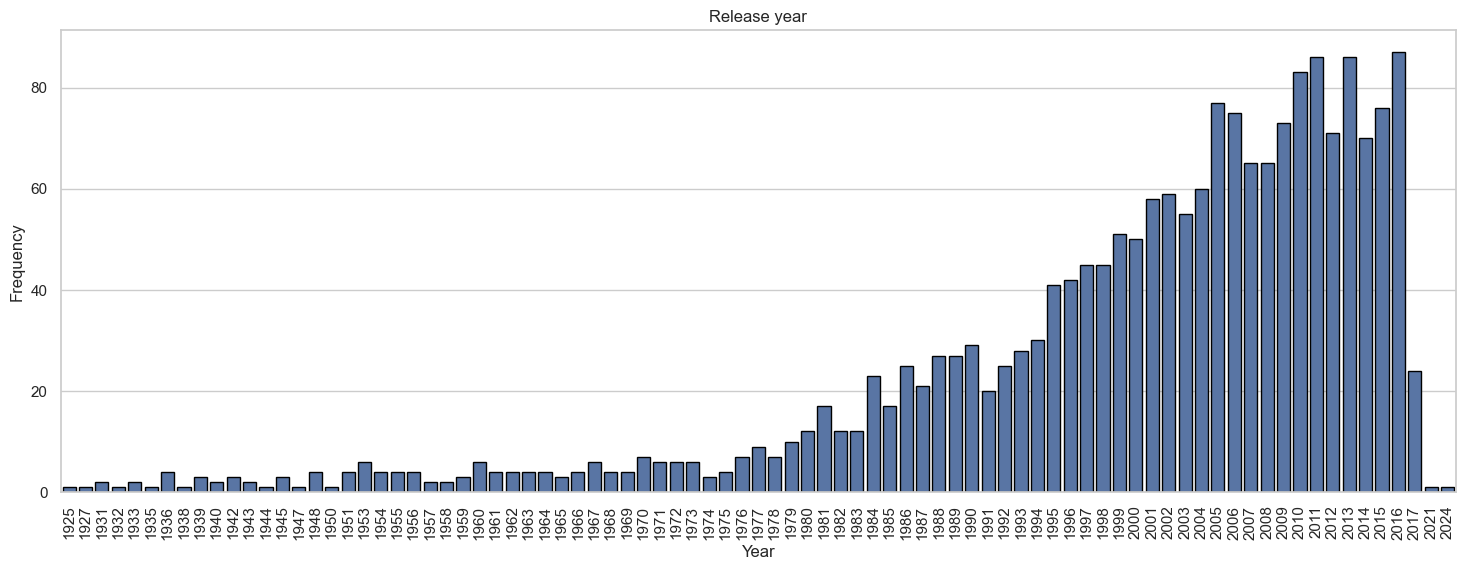

In [575]:
plt.figure(figsize=(18, 6))
sns.countplot(x='release_year', data=df, edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Release year')
plt.xticks(rotation=90)
plt.show()

- Release season:

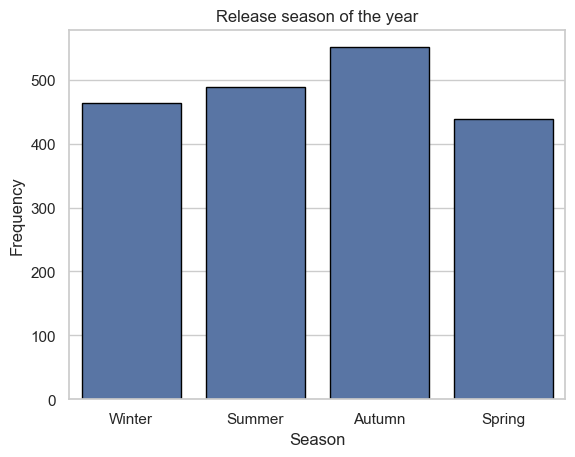

In [576]:
sns.countplot(x='season', data=df, edgecolor='black')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.title('Release season of the year')
plt.show()

- Release month:

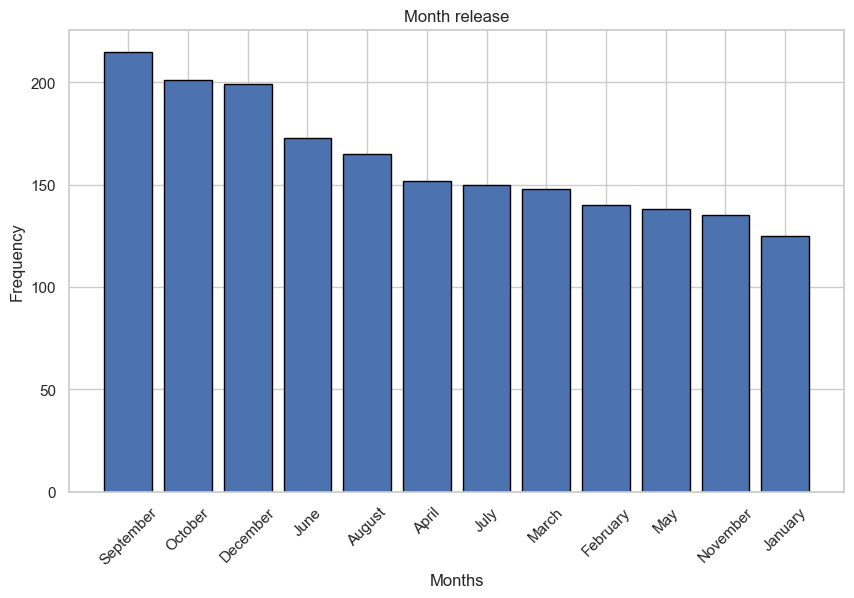

In [577]:
plt.figure(figsize=(10, 6))
frecuencias = df['release_month'].value_counts().sort_values(ascending=False)

plt.bar(frecuencias.index, frecuencias.values, edgecolor='black')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.title('Month release')
plt.xticks(rotation=45)
plt.show()

- Release decade:

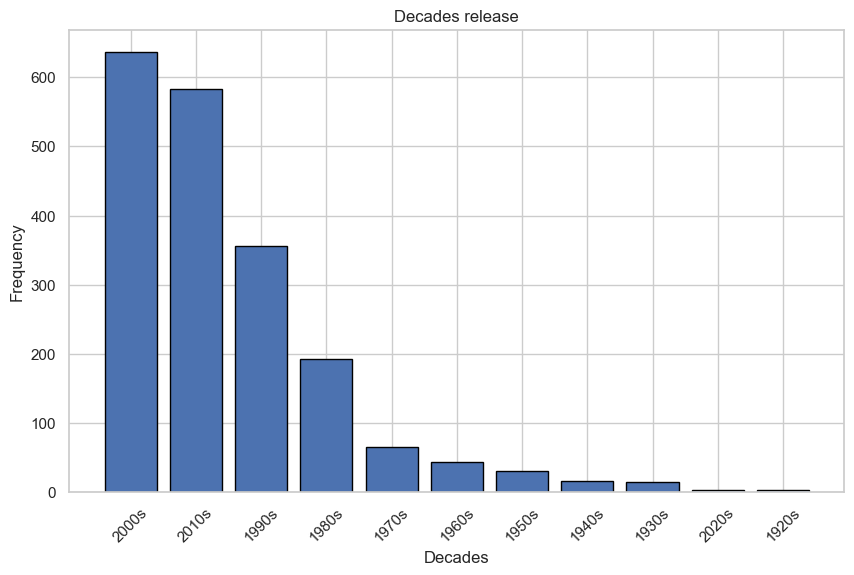

In [578]:
plt.figure(figsize=(10, 6))
frecuencias = df['decade'].value_counts().sort_values(ascending=False)
plt.bar(frecuencias.index, frecuencias.values, edgecolor='black')
plt.xlabel('Decades')
plt.ylabel('Frequency')
plt.title('Decades release')
plt.xticks(rotation=45)
plt.show()

### **Genres**

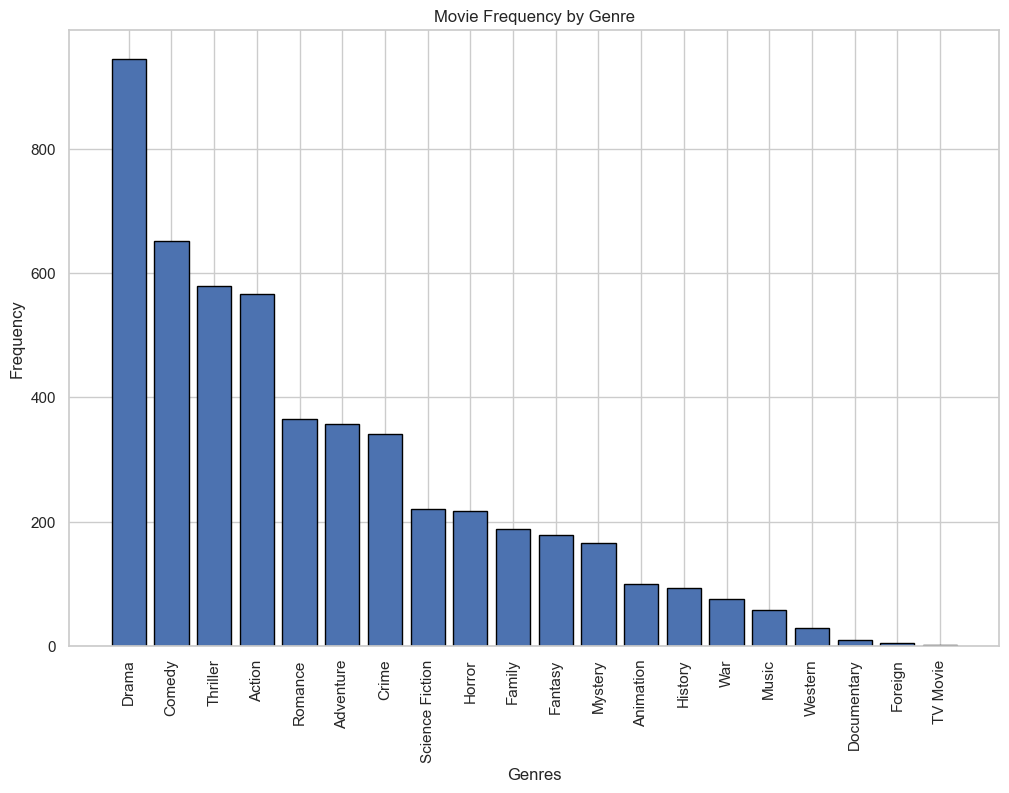

In [579]:
todos_los_generos = [genero for sublist in df['genres'] for genero in sublist]
frecuencias = Counter(todos_los_generos).most_common()
frecuencias_df = pd.DataFrame(frecuencias, columns=['genres', 'Frecuencia'])

plt.figure(figsize=(12, 8)) 
plt.bar(frecuencias_df['genres'], frecuencias_df['Frecuencia'], edgecolor='black')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Movie Frequency by Genre')
plt.xticks(rotation=90)

plt.show()

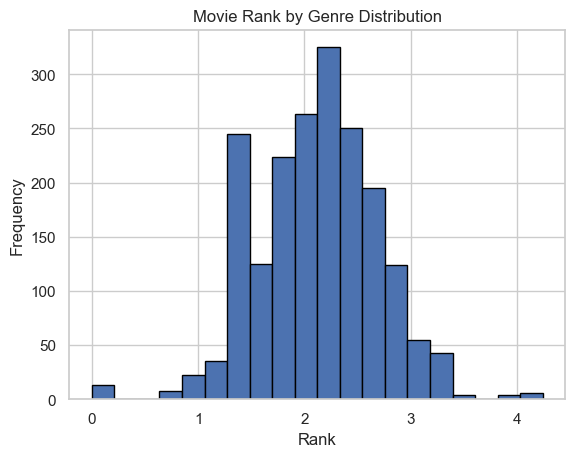

In [580]:
np.sqrt(df['genre_rank']).hist(bins=20, edgecolor='black')
plt.title('Movie Rank by Genre Distribution')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

## **Bivariate** analysis

### Mean **revenue** by movie **runtime**

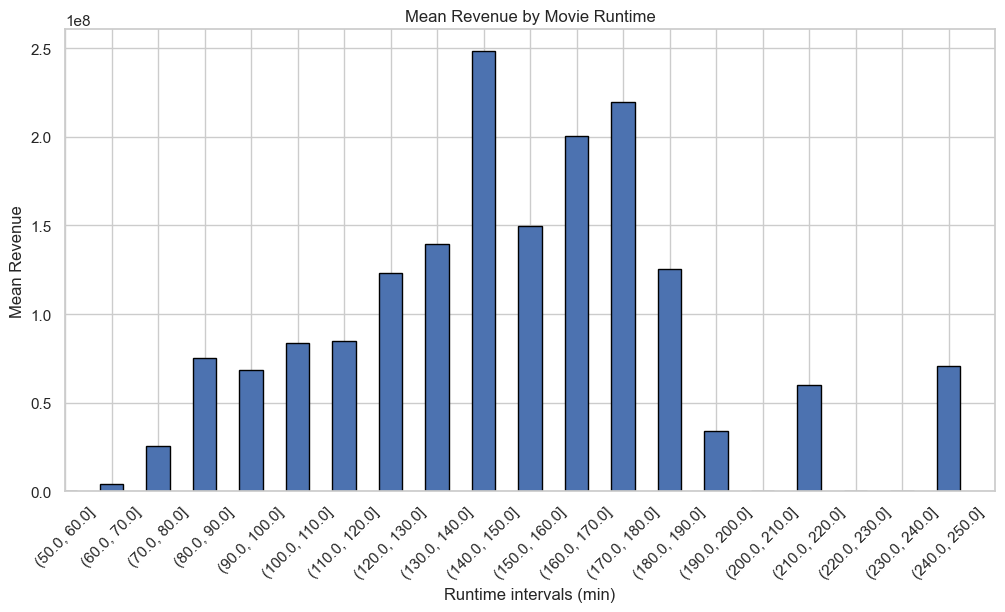

In [581]:
intervalos = pd.interval_range(start=0, end=df['runtime'].max() + 10, freq=10)
df['runtime_interval'] = pd.cut(df['runtime'], bins=intervalos)

# Calcular la media de la recaudación para cada intervalo de duración
media_recaudacion_por_intervalo = df.groupby('runtime_interval')['revenue'].mean()

plt.figure(figsize=(12, 6))
media_recaudacion_por_intervalo.plot(kind='bar', edgecolor='black')

plt.title('Mean Revenue by Movie Runtime')
plt.xlabel('Runtime intervals (min)')
plt.ylabel('Mean Revenue')
start_limit = 5 
end_limit = 25 
plt.xlim(start_limit, end_limit)
plt.xticks(rotation=45)
plt.show()

### Mean **revenue** by movie **budget**

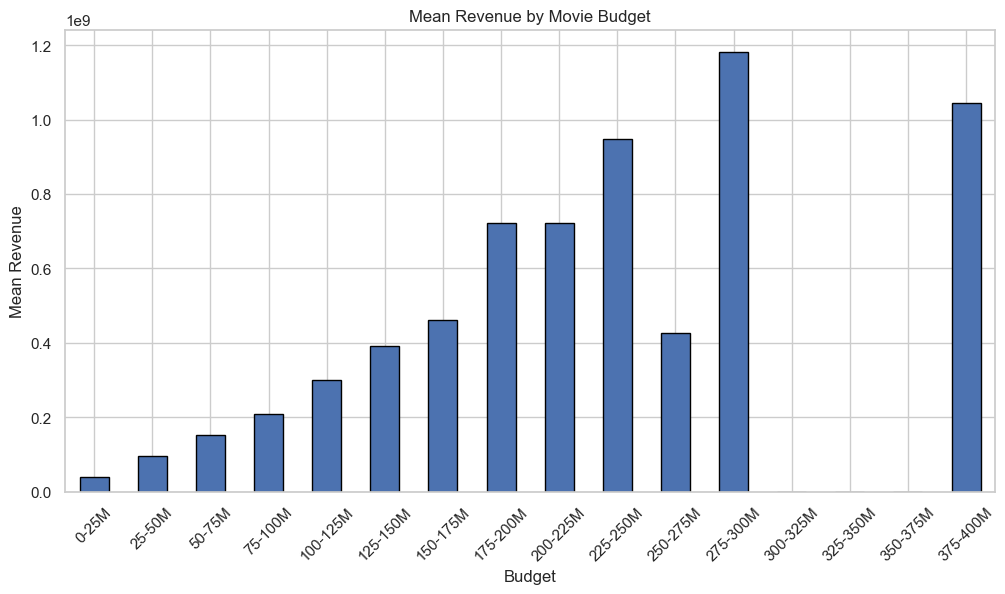

In [582]:
intervalos_presupuesto = pd.interval_range(start=0, end=df['budget'].max() + 25e6, freq=25e6)
df['presupuesto_intervalo'] = pd.cut(df['budget'], bins=intervalos_presupuesto)

media_recaudacion_por_presupuesto = df.groupby('presupuesto_intervalo')['revenue'].mean()

plt.figure(figsize=(12, 6))
media_recaudacion_por_presupuesto.plot(kind='bar', edgecolor='black')
plt.title('Mean Revenue by Movie Budget')
plt.xlabel('Budget')
plt.ylabel('Mean Revenue')
labels = [f'{int(interval.left/1e6)}-{int(interval.right/1e6)}M' for interval in media_recaudacion_por_presupuesto.index]
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
plt.show()

### Mean **revenue** by **release month**

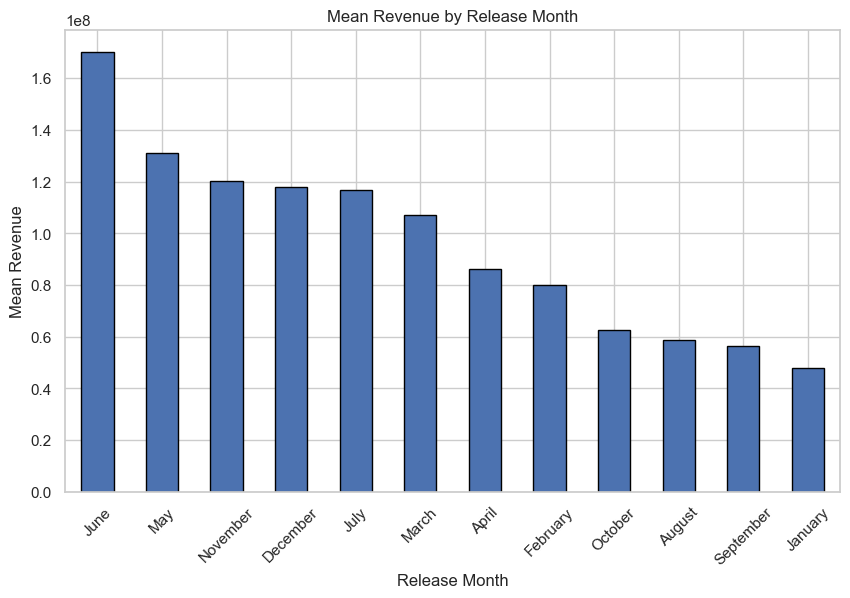

In [583]:
# Calcular la media de la recaudación para cada mes de estreno
media_recaudacion_por_mes = df.groupby('release_month')['revenue'].mean()
media_recaudacion_por_mes = media_recaudacion_por_mes.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
media_recaudacion_por_mes.plot(kind='bar', edgecolor='black')


plt.title('Mean Revenue by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Mean Revenue')
plt.xticks(range(len(media_recaudacion_por_mes)), [f'{i}' for i in media_recaudacion_por_mes.index], rotation=45)
plt.show()

### Mean revenue by **Season**

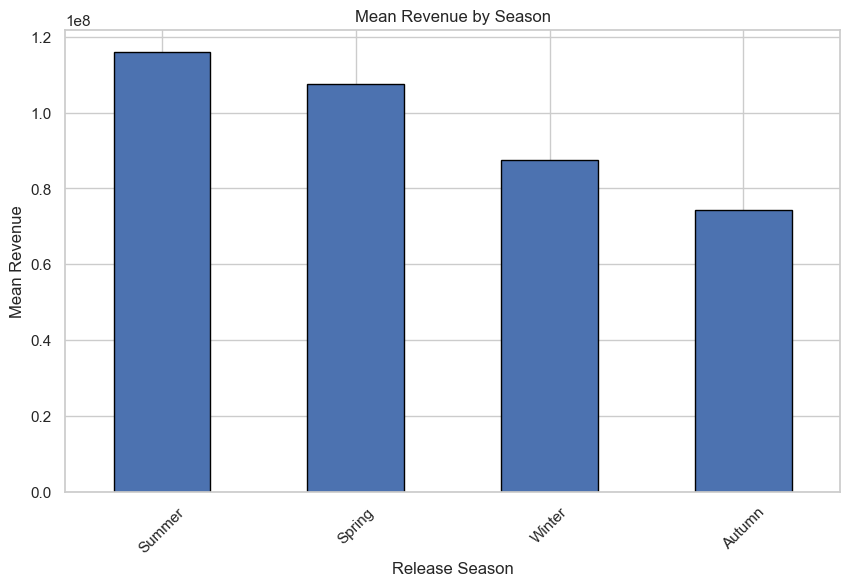

In [584]:
media_recaudacion_por_season = df.groupby('season')['revenue'].mean()
media_recaudacion_por_season = media_recaudacion_por_season.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
media_recaudacion_por_season.plot(kind='bar', edgecolor='black')


plt.title('Mean Revenue by Season')
plt.xlabel('Release Season')
plt.ylabel('Mean Revenue')
plt.xticks(range(len(media_recaudacion_por_season)), [f'{i}' for i in media_recaudacion_por_season.index], rotation=45)
plt.show()

### Mean revenue by **Decade**

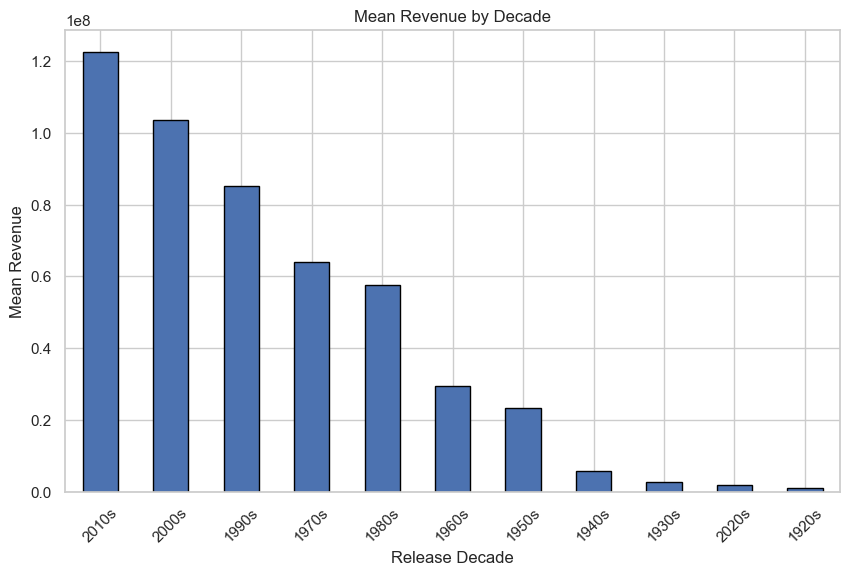

In [585]:
media_recaudacion_por_decada = df.groupby('decade')['revenue'].mean()
media_recaudacion_por_decada = media_recaudacion_por_decada.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
media_recaudacion_por_decada.plot(kind='bar', edgecolor='black')

plt.title('Mean Revenue by Decade')
plt.xlabel('Release Decade')
plt.ylabel('Mean Revenue')
plt.xticks(range(len(media_recaudacion_por_decada)), [f'{i}' for i in media_recaudacion_por_decada.index], rotation=45)
plt.show()

### Mean Revenue by **Genre**

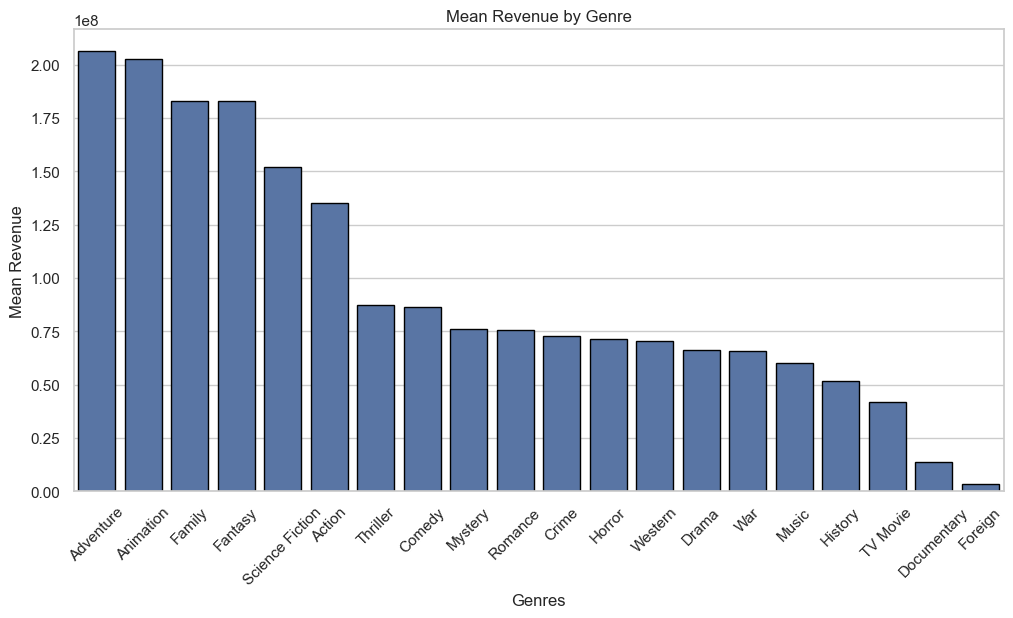

In [586]:
df_exploded = df.explode('genres')

# Calcular la media de recaudación por género
media_recaudacion = df_exploded.groupby('genres')['revenue'].mean().reset_index()
media_recaudacion = media_recaudacion.sort_values(by='revenue', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='genres', y='revenue', data=media_recaudacion, order=media_recaudacion['genres'], edgecolor='black')
plt.xlabel('Genres')
plt.ylabel('Mean Revenue')
plt.title('Mean Revenue by Genre')
plt.xticks(rotation=45)
plt.show()

### Mean Revenue by **Top 100 actor count**

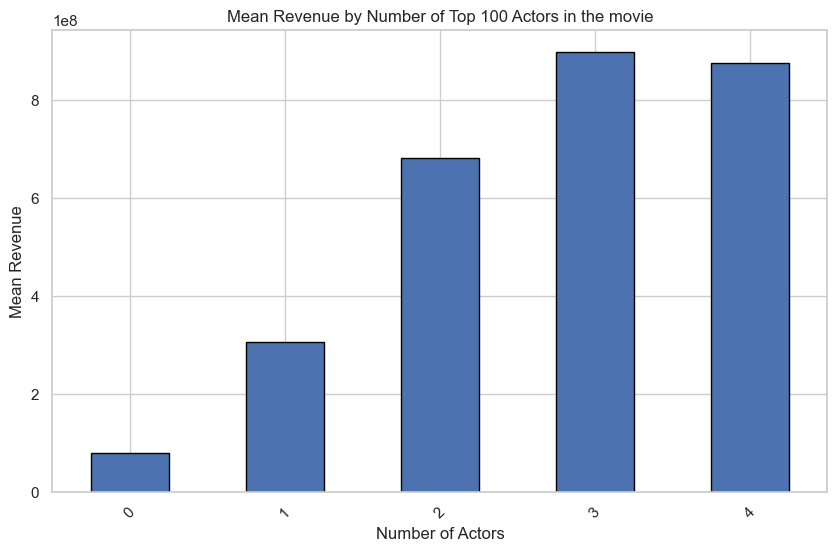

In [587]:
media_recaudacion = df.groupby('top_100_actor_count')['revenue'].mean()

plt.figure(figsize=(10, 6))
media_recaudacion.plot(kind='bar', edgecolor='black')

plt.title('Mean Revenue by Number of Top 100 Actors in the movie')
plt.xlabel('Number of Actors')
plt.ylabel('Mean Revenue')
plt.xticks(range(len(media_recaudacion)), [f'{i}' for i in media_recaudacion.index], rotation=45)
plt.show()

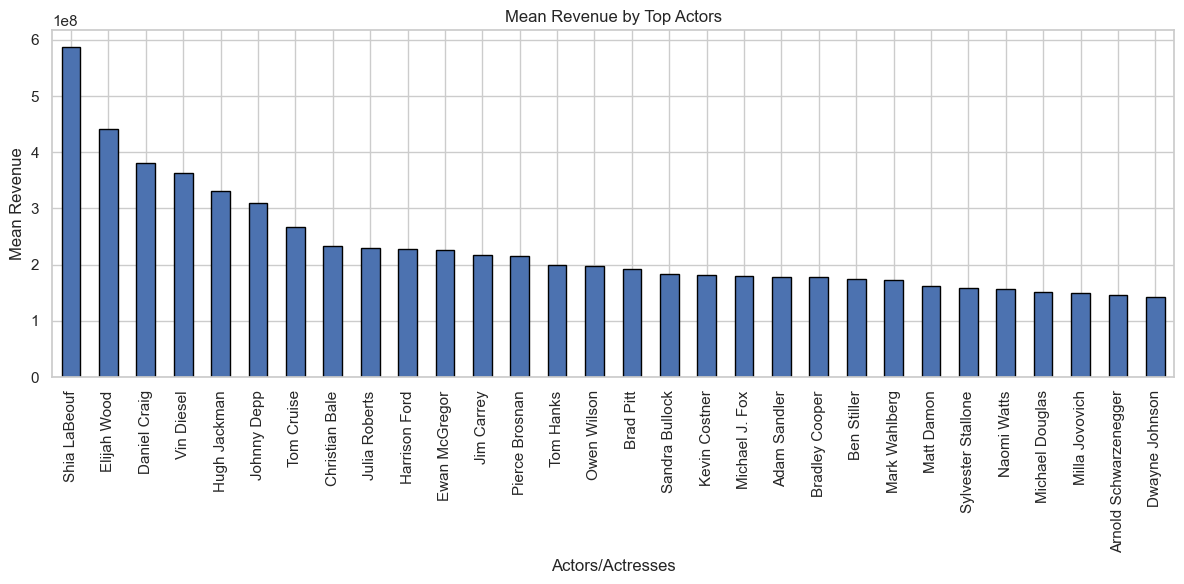

In [588]:
actor_counts = df['lead_actor'].value_counts()
actors_more_than_4_movies = actor_counts[actor_counts > 4].index.tolist()

df_filtered = df[df['lead_actor'].isin(actors_more_than_4_movies)]

media_recaudacion = df_filtered.groupby('lead_actor')['revenue'].mean()
media_recaudacion = media_recaudacion.sort_values(ascending=False).head(30)

plt.figure(figsize=(12, 6))
media_recaudacion.plot(kind='bar', edgecolor='black')

plt.title('Mean Revenue by Top Actors')
plt.xlabel('Actors/Actresses')
plt.ylabel('Mean Revenue')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

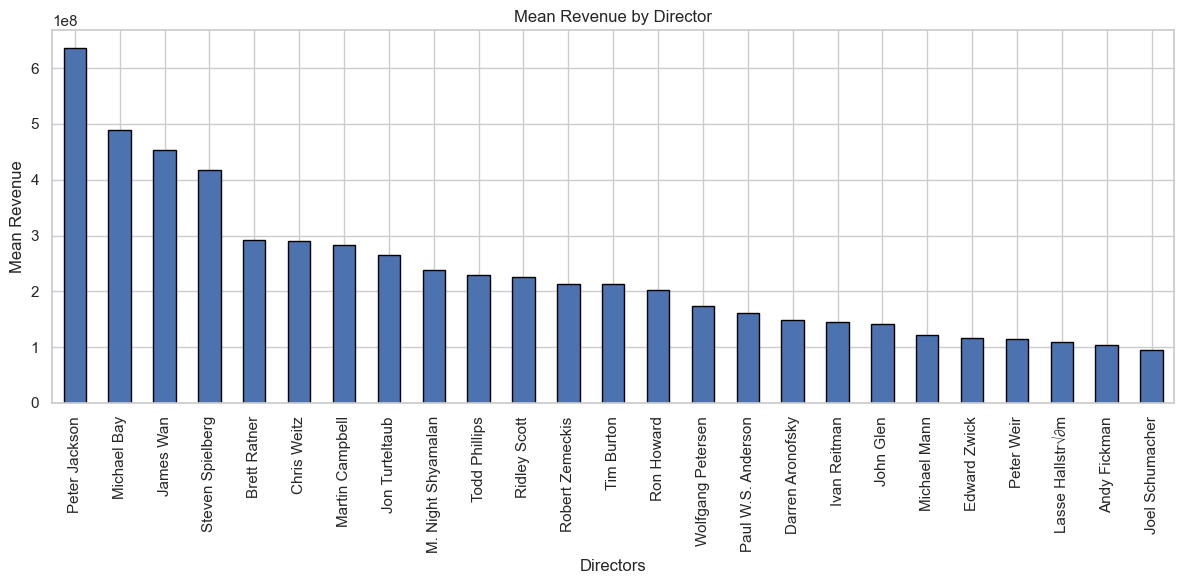

In [589]:

director_counts = df['director'].value_counts()
directors_more_than_4_movies = director_counts[director_counts > 4].index.tolist()
df_filtered = df[df['director'].isin(directors_more_than_4_movies)]

media_recaudacion = df_filtered.groupby('director')['revenue'].mean()
media_recaudacion = media_recaudacion.sort_values(ascending=False).head(25)

plt.figure(figsize=(12, 6))
media_recaudacion.plot(kind='bar', edgecolor='black')

plt.title('Mean Revenue by Director')
plt.xlabel('Directors')
plt.ylabel('Mean Revenue')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

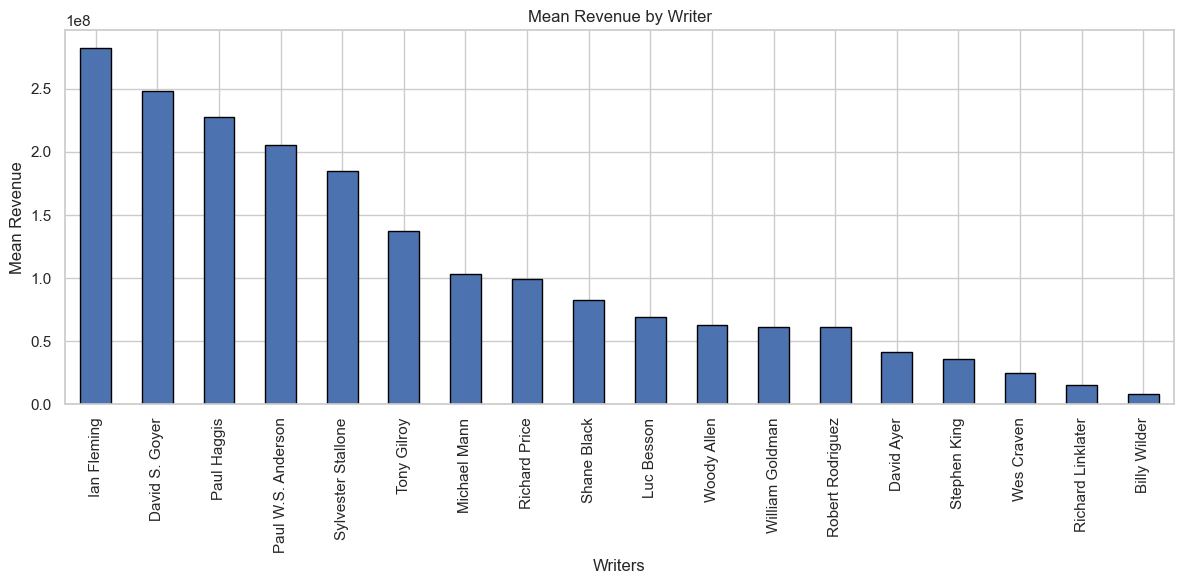

In [590]:
writer_counts = df['writer'].value_counts()
writers_more_than_4_movies = writer_counts[writer_counts > 4].index.tolist()

df_filtered = df[df['writer'].isin(writers_more_than_4_movies)]

media_recaudacion = df_filtered.groupby('writer')['revenue'].mean()
media_recaudacion = media_recaudacion.sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
media_recaudacion.plot(kind='bar', edgecolor='black')

plt.title('Mean Revenue by Writer')
plt.xlabel('Writers')
plt.ylabel('Mean Revenue')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Step 3: **Feature transformation**

- After the EDA inspection, we find out the features which will be interesting for the model training. From those, some needs log transformation in order to normalize distribution.

In [591]:
features = ['runtime','lead_actor', 'supporting_actor_1', 'supporting_actor_2', 'director','writer','has_top_25_director','has_top_25_writer', 'has_top_25_company', 
            'in_english', 'produced_in_US','release_month','release_year','decade','season']

log_features = ['revenue','budget','genre_rank','top_100_actor_count','num_production_countries', 'num_production_companies',
                'company_rank', 'actor_rank', 'director_rank', 'writer_rank']

In [592]:
columns_to_include = list(set(features + log_features))
df = df[columns_to_include]

- The training will be made in two steps, bearing in mind the great amounts and variety of revenues. We establish the limit in 20M, searching for the data to be the closest possible in length, with also logic when it comes to consider what could be considered a huge movie or another more humble.

In [593]:
df1 = df[df.revenue >= 20000000]
df2 = df[df.revenue < 20000000]

for feat in log_features:
    df1[feat] = np.log1p(df1[feat])
    df2[feat] = np.log1p(df2[feat])

# Step 4: Machine Learning training model

- We establish our target, and drop the columns which will not be useful for the training. For further information, consult the notebooks.

In [594]:
target = 'revenue'
df1.drop(columns=['lead_actor','supporting_actor_1','supporting_actor_2','director','writer'], inplace=True)
df2.drop(columns=['lead_actor','supporting_actor_1','supporting_actor_2','director','writer'], inplace=True)

In [595]:
print("There are", len(df1), "movies with revenues more than 20M, and", len(df2), "movies with less than 20M")

There are 1230 movies with revenues more than 20M, and 711 movies with less than 20M


- We apply a Label Encoder for the time features.

In [596]:
cols = ['release_month','decade','season','release_year']
le = LabelEncoder()
for column in cols:
   df1[column] = le.fit_transform(df1[column])
   df2[column] = le.fit_transform(df2[column])

In [597]:
correlation_with_target = abs(df1.corr()[target])
correlation_with_target = correlation_with_target.sort_values(ascending=False)
correlation_with_target

revenue                     1.000000
writer_rank                 0.827230
director_rank               0.803563
budget                      0.537281
has_top_25_company          0.444491
actor_rank                  0.434286
company_rank                0.430987
has_top_25_director         0.398165
top_100_actor_count         0.327617
has_top_25_writer           0.294852
release_year                0.202665
decade                      0.195851
runtime                     0.160762
produced_in_US              0.160735
num_production_companies    0.143958
in_english                  0.129976
genre_rank                  0.094948
num_production_countries    0.088637
season                      0.052529
release_month               0.027418
Name: revenue, dtype: float64

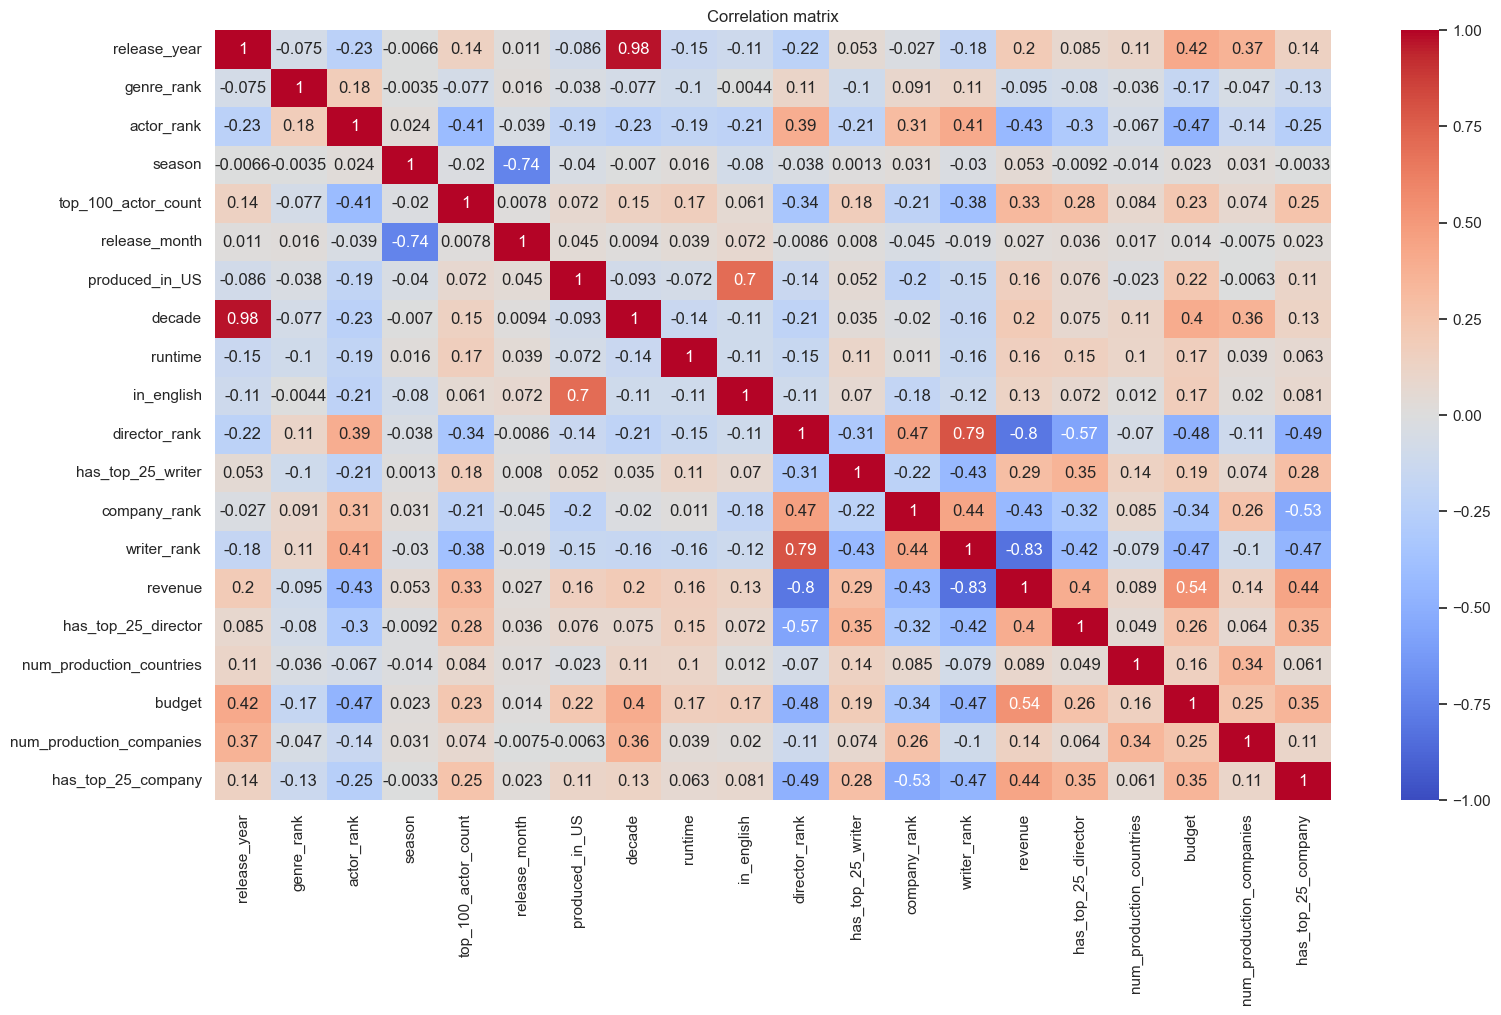

In [598]:
plt.figure(figsize=(18, 10))
sns.heatmap(df1.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

- We drop "decade" in order to avoid colinearity in movies above 20M

In [599]:
df1.drop(columns=['decade'], inplace=True)

Now let's see the movies below 20M, the normally smaller budget ones.

In [600]:
correlation_with_target = abs(df2.corr()[target])
correlation_with_target = correlation_with_target.sort_values(ascending=False)
correlation_with_target

revenue                     1.000000
writer_rank                 0.378734
budget                      0.349692
director_rank               0.289817
actor_rank                  0.143289
company_rank                0.136673
produced_in_US              0.123523
release_year                0.069436
in_english                  0.069414
decade                      0.068699
has_top_25_company          0.062455
num_production_companies    0.052166
runtime                     0.049772
top_100_actor_count         0.039603
genre_rank                  0.034192
has_top_25_director         0.023806
season                      0.022553
num_production_countries    0.020175
has_top_25_writer           0.019018
release_month               0.015828
Name: revenue, dtype: float64

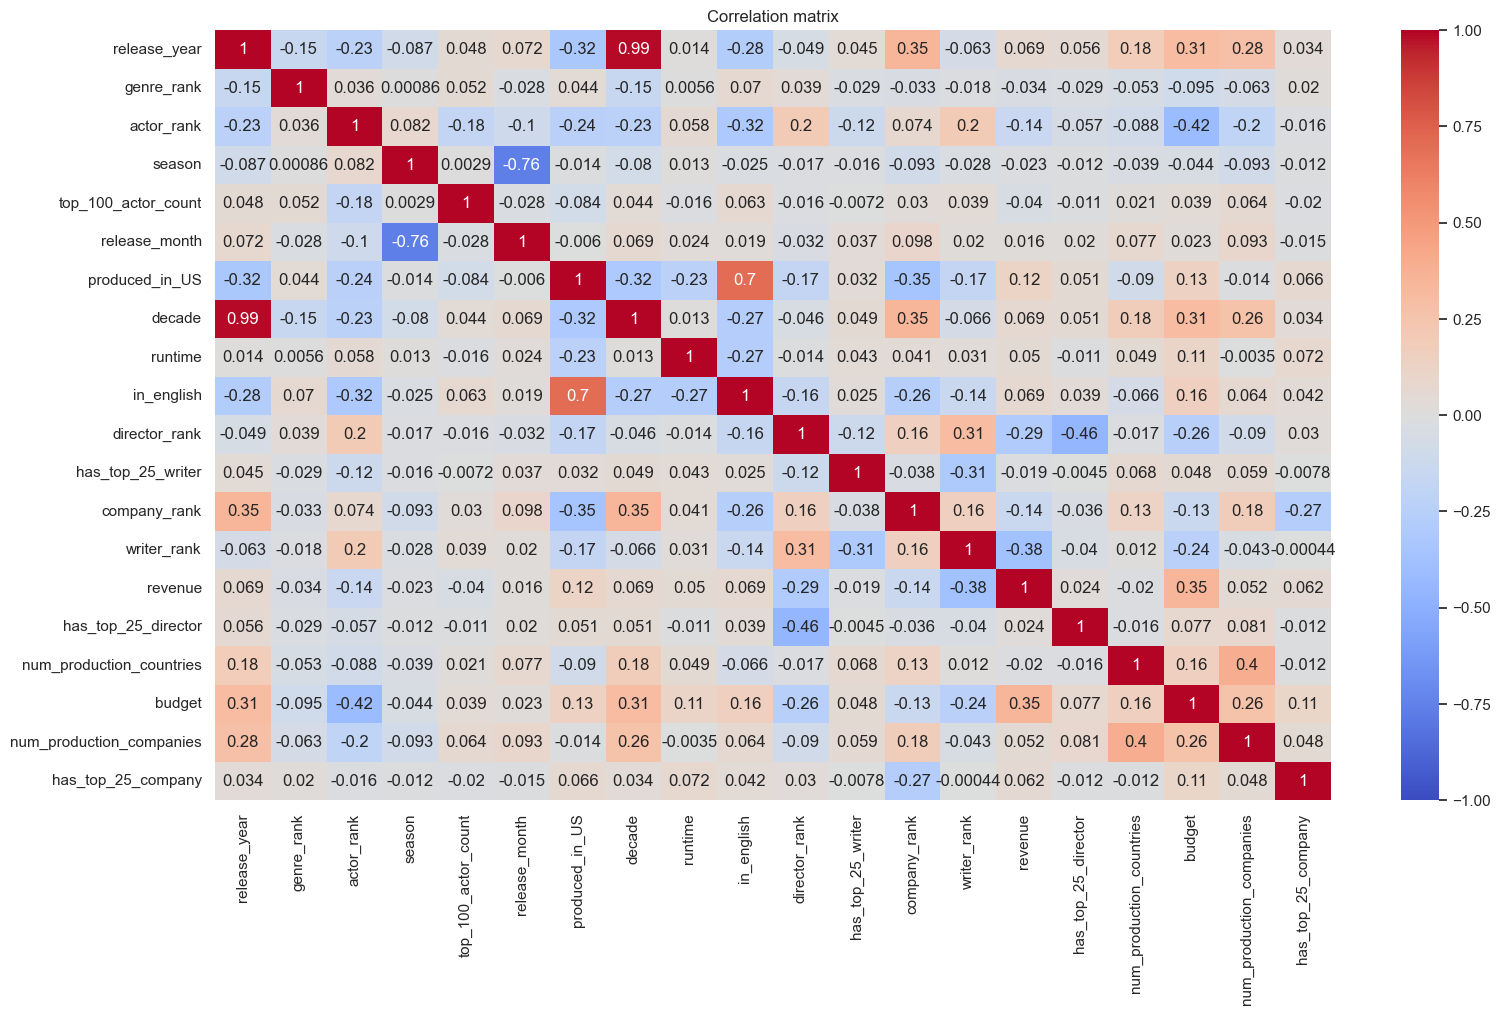

In [601]:
plt.figure(figsize=(18, 10))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

- We also drop "decade" in order to avoid colinearity in movies below 20M.

In [602]:
df2.drop(columns=['decade'], inplace=True)

## Train/Test split

In [603]:
X1 = df1.drop(target, axis = 1)
y1 = df1[target]

X2 = df2.drop(target, axis = 1)
y2 = df2[target]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

## Pipeline (XGBoost)

- The model for training used in this notebook will be XGBoost, the one with best results and the best hiperparameters. I also performed training using RandomForest and LightGBM, but they were not as good (even though LGBM was close). In order to know more, I insist to go check the notebooks.

In [604]:
# Select the numeric features
numeric_features = ['budget', 'top_100_actor_count', 'num_production_countries', 'genre_rank', 'runtime']

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', XGBRegressor(
        alpha=0.005,      
        reg_lambda=0.005,   
        gamma=0.005          
    ))
])

In [605]:
param_grid_1 = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__max_depth': [2,3,4],
    'regressor__learning_rate': [0.01, 0.05],
    'regressor__subsample': [0.5, 0.6, 0.7],
    'regressor__colsample_bytree': [0.8, 0.9, 1],
}

param_grid_2 = {
    'regressor__n_estimators': [400, 500, 600],
    'regressor__max_depth': [1,2,3],
    'regressor__learning_rate': [0.005, 0.01, 0.05],
    'regressor__subsample': [0.8, 0.9, 1],
    'regressor__colsample_bytree': [0.9, 0.95, 1],
}

### Pipeline for model 1

In [606]:
# Entrenar el modelo
pipeline.fit(X1_train, y1_train)
grid_search_1 = GridSearchCV(pipeline, param_grid_1, cv=10, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
grid_search_1.fit(X1_train, y1_train)
print("Mejores hiperparámetros:", grid_search_1.best_params_)

Mejores hiperparámetros: {'regressor__colsample_bytree': 1, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 0.7}


In [607]:
# Realizar predicciones en el conjunto de prueba con el mejor modelo encontrado
best_model_high = grid_search_1.best_estimator_
y1_pred_log = best_model_high.predict(X1_test)

# Revertir la transformación logarítmica
y1_pred = np.expm1(y1_pred_log)
y1_test_actual = np.expm1(y1_test)

In [608]:
mae_high = mean_absolute_error(y1_test_actual, y1_pred)
mape_high = mean_absolute_percentage_error(y1_test_actual, y1_pred) * 100
rmsle_high = np.sqrt(mean_squared_log_error(y1_test_actual, y1_pred))

print(f"MAE for high revenue movies: {mae_high:.2f}")
print(f"MAPE for high revenue movies: {mape_high:.2f}%")
print(f"RMSLE for high revenue movies: {rmsle_high:.2f}")

MAE for high revenue movies: 44192424.02
MAPE for high revenue movies: 28.22%
RMSLE for high revenue movies: 0.36


- **Why to also bear in mind the RMSLE?**

- Handling of Extreme Values: RMSLE is less sensitive to extreme values compared to MAPE. This makes it suitable for data with a wide range of values, such as movie revenues, which can vary from flops to blockbuster hits.

- Penalization of Underestimations and Overestimations: RMSLE penalizes underestimations more than overestimations (depending on how you view the symmetry of the error in the logarithmic space), which may be desirable in certain business or investment contexts where underestimations have different consequences than overestimations.

- Logarithmic Basis: When working with logarithmic transformations, RMSLE measures the error in the same transformed space, providing consistent evaluations when the original data has been log-transformed to handle asymmetry or excessive dispersion.

#### Model importances

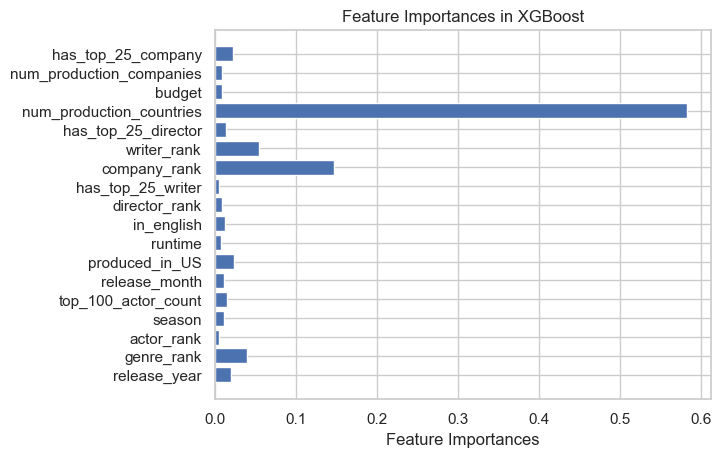

In [609]:
xgb_model = pipeline.named_steps['regressor']

# Obtener las importancias de las características
feature_importances = xgb_model.feature_importances_

feature_names = X1_train.columns.tolist()

plt.barh(np.arange(len(feature_importances)), feature_importances, align='center')
plt.yticks(np.arange(len(feature_importances)), feature_names)
plt.xlabel('Feature Importances')
plt.title('Feature Importances in XGBoost')
plt.show()

### Pipeline for model 2

In [610]:
# Entrenar el modelo
pipeline.fit(X2_train, y2_train)
grid_search_2 = GridSearchCV(pipeline, param_grid_2, cv=10, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
grid_search_2.fit(X2_train, y2_train)
print("Mejores hiperparámetros:", grid_search_2.best_params_)

Mejores hiperparámetros: {'regressor__colsample_bytree': 1, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 600, 'regressor__subsample': 0.8}


In [611]:
# Realizar predicciones en el conjunto de prueba con el mejor modelo encontrado
best_model_low = grid_search_2.best_estimator_
y2_pred_log = best_model_low.predict(X2_test)

# Revertir la transformación logarítmica
y2_pred = np.expm1(y2_pred_log)
y2_test_actual = np.expm1(y2_test)

In [612]:
mae_low = mean_absolute_error(y2_test_actual, y2_pred)
mape_low = mean_absolute_percentage_error(y2_test_actual, y2_pred) * 100
rmsle_low = np.sqrt(mean_squared_log_error(y2_test_actual, y2_pred))

print(f"MAE for low revenue movies: {mae_low:.2f}")
print(f"MAPE for low revenue movies: {mape_low:.2f}%")
print(f"RMSLE for low revenue movies: {rmsle_low:.2f}")

MAE for low revenue movies: 1520581.41
MAPE for low revenue movies: 21.62%
RMSLE for low revenue movies: 0.30


#### Model importances

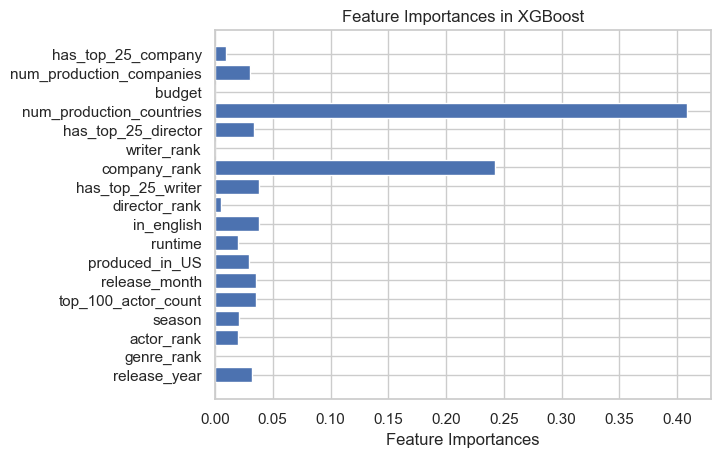

In [613]:
xgb_model = pipeline.named_steps['regressor']

# Obtener las importancias de las características
feature_importances = xgb_model.feature_importances_

feature_names = X1_train.columns.tolist()

plt.barh(np.arange(len(feature_importances)), feature_importances, align='center')
plt.yticks(np.arange(len(feature_importances)), feature_names)
plt.xlabel('Feature Importances')
plt.title('Feature Importances in XGBoost')
plt.show()

# Step 5: **Conclusions and Future Work**

- The best errors obtained were using XGBoostRegressor, finding: 

1) MAE of 44M, MAPE of 28.22% and RMSLE of 0.36 for high revenues

2) MAE of 1,5M, MAPE of 21.62% and RMSLE of 0.30 for low revenues


- I consider these results beyond the result scope I had in the first place. For bigger movies, as The Avengers or Fast and Furious, 44M (or 28%) of error is very little compared to the billions of revenue obtained by the produciton companies. This accuracy is even better for expected low revenue movies, for an approximate 22% error.

- For the future streamlit prediction demonstration, as two models were trained, we would use the high or low revenue model depending on the expected revenue the movie would need in order to have benefit. In cinema, for a movie to have benefit, it needs more than double the budget invested, so for a movie with 10M budget, we would need 20M dollars.

- For future work, I would find interesting to have even more features, as people decide to go to the cinema for several different reasons:

1. Social media is very important. To have a feature based on impressions in the release week for movies similar to the one you would like to release. People talk, gossips, tweets, posts on Instagram, etc. 

2. Sequels are very important. It would be great to have another feature to distinguish the movies that are sequel, or directly share universe with others (for example, the Marvel Cinematic Universe)

3. Actors are not based only on career. They have ups and downs. They might be trending when you choose to release your movie (for instance, Timothée Chalamet right now is at his peak of his career), and several more, as they were famous, might have done several flops and people don't care about them anymore.

4. More movies are needed. There are a few exceptions but most of the movies stopped being updated in 2017-2018, so there is no reflection of the box office nowadays. In a project where we simulate a movie release in 2024, this is a very important feature to bear in mind too.